## Tiny NeRF (A PyTorch implementation)

So, this weekend, I was catching up on this _cool paper_ titled [*NeRF: Representing scenes as neural radiance fields for view synthesis*](https://arxiv.org/abs/2003.08934)!

The authors released a TensorFlow implementation [here](https://github.com/bmild/nerf). Deciding to delve deeper, I ported their code to PyTorch, cause why not!

> *DISCLAIMER*: This notebook (and repository) is work-in-progress. Although I have rigorously tested most modules in here (to faithfully replicate the original implementation), my implementation at places deviates from the authors'. Comments/criticism welcome!

> All functions that have a `#TESTED` under the docstring imply that they have been tested against their corresponding tensorflow impls.

In [1]:
# Import all the good stuff
from typing import Optional

import numpy as np
import torch
import matplotlib.pyplot as plt

## A few utility functions

#### Bridging PyTorch and TensorFlow functionality

There's plenty of differences in function signatures (and in functionality) b/w PyTorch and TensorFlow. Here's a few modules that help bridge the gap (for this particular impl).

In [2]:
def meshgrid_xy(tensor1: torch.Tensor, tensor2: torch.Tensor) -> (torch.Tensor, torch.Tensor):
    """Mimick np.meshgrid(..., indexing="xy") in pytorch. torch.meshgrid only allows "ij" indexing.
    (If you're unsure what this means, safely skip trying to understand this, and run a tiny example!)

    Args:
      tensor1 (torch.Tensor): Tensor whose elements define the first dimension of the returned meshgrid.
      tensor2 (torch.Tensor): Tensor whose elements define the second dimension of the returned meshgrid.
    """
    # TESTED
    ii, jj = torch.meshgrid(tensor1, tensor2)
    return ii.transpose(-1, -2), jj.transpose(-1, -2)


def cumprod_exclusive(tensor: torch.Tensor) -> torch.Tensor:
  r"""Mimick functionality of tf.math.cumprod(..., exclusive=True), as it isn't available in PyTorch.

  Args:
    tensor (torch.Tensor): Tensor whose cumprod (cumulative product, see `torch.cumprod`) along dim=-1
      is to be computed.

  Returns:
    cumprod (torch.Tensor): cumprod of Tensor along dim=-1, mimiciking the functionality of
      tf.math.cumprod(..., exclusive=True) (see `tf.math.cumprod` for details).
  """
  # TESTED
  # Only works for the last dimension (dim=-1)
  dim = -1
  # Compute regular cumprod first (this is equivalent to `tf.math.cumprod(..., exclusive=False)`).
  cumprod = torch.cumprod(tensor, dim)
  # "Roll" the elements along dimension 'dim' by 1 element.
  cumprod = torch.roll(cumprod, 1, dim)
  # Replace the first element by "1" as this is what tf.cumprod(..., exclusive=True) does.
  cumprod[..., 0] = 1.

  return cumprod

#### Compute the "bundle" of rays through all pixels of an image.

In [3]:
def get_ray_bundle(height: int, width: int, focal_length: float, tform_cam2world: torch.Tensor):
  r"""Compute the bundle of rays passing through all pixels of an image (one ray per pixel).

  Args:
    height (int): Height of an image (number of pixels).
    width (int): Width of an image (number of pixels).
    focal_length (float or torch.Tensor): Focal length (number of pixels, i.e., calibrated intrinsics).
    tform_cam2world (torch.Tensor): A 6-DoF rigid-body transform (shape: :math:`(4, 4)`) that
      transforms a 3D point from the camera frame to the "world" frame for the current example.

  Returns:
    ray_origins (torch.Tensor): A tensor of shape :math:`(width, height, 3)` denoting the centers of
      each ray. `ray_origins[i][j]` denotes the origin of the ray passing through pixel at
      row index `j` and column index `i`.
      (TODO: double check if explanation of row and col indices convention is right).
    ray_directions (torch.Tensor): A tensor of shape :math:`(width, height, 3)` denoting the
      direction of each ray (a unit vector). `ray_directions[i][j]` denotes the direction of the ray
      passing through the pixel at row index `j` and column index `i`.
      (TODO: double check if explanation of row and col indices convention is right).
  """
  # TESTED
  ii, jj = meshgrid_xy(
      torch.arange(width).to(tform_cam2world),
      torch.arange(height).to(tform_cam2world)
  )
  directions = torch.stack([(ii - width * .5) / focal_length,
                            -(jj - height * .5) / focal_length,
                            -torch.ones_like(ii)
                           ], dim=-1)
  ray_directions = torch.sum(directions[..., None, :] * tform_cam2world[:3, :3], dim=-1)
  ray_origins = tform_cam2world[:3, -1].expand(ray_directions.shape)
  return ray_origins, ray_directions

#### Compute "query" 3D points given the "bundle" of rays.

We assume that a _near_ and a _far_ clipping distance are provided that delineate the volume of interest. Each ray is evaluated only within these bounds. We randomly sample points along each ray, while trying to ensure most parts of the ray's trajectory are spanned.

In [4]:
def compute_query_points_from_rays(
    ray_origins: torch.Tensor,
    ray_directions: torch.Tensor,
    near_thresh: float,
    far_thresh: float,
    num_samples: int,
    randomize: Optional[bool] = True
) -> (torch.Tensor, torch.Tensor):
  r"""Compute query 3D points given the "bundle" of rays. The near_thresh and far_thresh
  variables indicate the bounds within which 3D points are to be sampled.

  Args:
    ray_origins (torch.Tensor): Origin of each ray in the "bundle" as returned by the
      `get_ray_bundle()` method (shape: :math:`(width, height, 3)`).
    ray_directions (torch.Tensor): Direction of each ray in the "bundle" as returned by the
      `get_ray_bundle()` method (shape: :math:`(width, height, 3)`).
    near_thresh (float): The 'near' extent of the bounding volume (i.e., the nearest depth
      coordinate that is of interest/relevance).
    far_thresh (float): The 'far' extent of the bounding volume (i.e., the farthest depth
      coordinate that is of interest/relevance).
    num_samples (int): Number of samples to be drawn along each ray. Samples are drawn
      randomly, whilst trying to ensure "some form of" uniform spacing among them.
    randomize (optional, bool): Whether or not to randomize the sampling of query points.
      By default, this is set to `True`. If disabled (by setting to `False`), we sample
      uniformly spaced points along each ray in the "bundle".

  Returns:
    query_points (torch.Tensor): Query points along each ray
      (shape: :math:`(width, height, num_samples, 3)`).
    depth_values (torch.Tensor): Sampled depth values along each ray
      (shape: :math:`(num_samples)`).
  """
  # TESTED
  # shape: (num_samples)
  depth_values = torch.linspace(near_thresh, far_thresh, num_samples).to(ray_origins)
  if randomize is True:
    # ray_origins: (width, height, 3)
    # noise_shape = (width, height, num_samples)
    noise_shape = list(ray_origins.shape[:-1]) + [num_samples]
    # depth_values: (num_samples)
    depth_values = depth_values \
        + torch.rand(noise_shape).to(ray_origins) * (far_thresh
            - near_thresh) / num_samples
  # (width, height, num_samples, 3) = (width, height, 1, 3) + (width, height, 1, 3) * (num_samples, 1)
  # query_points:  (width, height, num_samples, 3)
  query_points = ray_origins[..., None, :] + ray_directions[..., None, :] * depth_values[..., :, None]
  # TODO: Double-check that `depth_values` returned is of shape `(num_samples)`.
  return query_points, depth_values

#### Volumetric rendering

> **NOTE**: This volumetric rendering module (like the authors' tiny_nerf [Colab notebook](https://colab.research.google.com/github/bmild/nerf/blob/master/tiny_nerf.ipynb) does not implement 5D input (which includes view directions, in addition to X, Y, Z coordinates). It also does not implement the hierarchical sampling procedure. For those implementations, refer to the other complete examples in the repo.

In [5]:
def render_volume_density(
    radiance_field: torch.Tensor,
    ray_origins: torch.Tensor,
    depth_values: torch.Tensor
) -> (torch.Tensor, torch.Tensor, torch.Tensor):
  r"""Differentiably renders a radiance field, given the origin of each ray in the
  "bundle", and the sampled depth values along them.

  Args:
    radiance_field (torch.Tensor): A "field" where, at each query location (X, Y, Z),
      we have an emitted (RGB) color and a volume density (denoted :math:`\sigma` in
      the paper) (shape: :math:`(width, height, num_samples, 4)`).
    ray_origins (torch.Tensor): Origin of each ray in the "bundle" as returned by the
      `get_ray_bundle()` method (shape: :math:`(width, height, 3)`).
    depth_values (torch.Tensor): Sampled depth values along each ray
      (shape: :math:`(num_samples)`).

  Returns:
    rgb_map (torch.Tensor): Rendered RGB image (shape: :math:`(width, height, 3)`).
    depth_map (torch.Tensor): Rendered depth image (shape: :math:`(width, height)`).
    acc_map (torch.Tensor): # TODO: Double-check (I think this is the accumulated
      transmittance map).
  """
  # TESTED
  sigma_a = torch.nn.functional.relu(radiance_field[..., 3])
  rgb = torch.sigmoid(radiance_field[..., :3])
  one_e_10 = torch.tensor([1e10], dtype=ray_origins.dtype, device=ray_origins.device)
  dists = torch.cat((depth_values[..., 1:] - depth_values[..., :-1],
                  one_e_10.expand(depth_values[..., :1].shape)), dim=-1)
  alpha = 1. - torch.exp(-sigma_a * dists)
  weights = alpha * cumprod_exclusive(1. - alpha + 1e-10)

  rgb_map = (weights[..., None] * rgb).sum(dim=-2)
  depth_map = (weights * depth_values).sum(dim=-1)
  acc_map = weights.sum(-1)

  return rgb_map, depth_map, acc_map

#### Positional encoding

Another interesting tweak used in NeRF is "positional encoding", which postulates the use of a mapping to higher dimensional space (using a basis set of high-frequency functions). This greatly enhances the model's capability to capture high-frequency variations.

In [6]:
def positional_encoding(
    tensor, num_encoding_functions=6, include_input=True, log_sampling=True
) -> torch.Tensor:
  r"""Apply positional encoding to the input.

  Args:
    tensor (torch.Tensor): Input tensor to be positionally encoded.
    num_encoding_functions (optional, int): Number of encoding functions used to
        compute a positional encoding (default: 6).
    include_input (optional, bool): Whether or not to include the input in the
        computed positional encoding (default: True).
    log_sampling (optional, bool): Sample logarithmically in frequency space, as
        opposed to linearly (default: True).

  Returns:
    (torch.Tensor): Positional encoding of the input tensor.
  """
  # TESTED
  # Trivially, the input tensor is added to the positional encoding.
  encoding = [tensor] if include_input else []
  # Now, encode the input using a set of high-frequency functions and append the
  # resulting values to the encoding.
  frequency_bands = None
  if log_sampling:
      frequency_bands = 2.0 ** torch.linspace(
            0.0,
            num_encoding_functions - 1,
            num_encoding_functions,
            dtype=tensor.dtype,
            device=tensor.device,
        )
  else:
      frequency_bands = torch.linspace(
          2.0 ** 0.0,
          2.0 ** (num_encoding_functions - 1),
          num_encoding_functions,
          dtype=tensor.dtype,
          device=tensor.device,
      )

  for freq in frequency_bands:
      for func in [torch.sin, torch.cos]:
          encoding.append(func(tensor * freq))

  # Special case, for no positional encoding
  if len(encoding) == 1:
      return encoding[0]
  else:
      return torch.cat(encoding, dim=-1)

## TinyNeRF: Network architecture

In [7]:
class VeryTinyNerfModel(torch.nn.Module):
  r"""Define a "very tiny" NeRF model comprising three fully connected layers.
  """
  def __init__(self, filter_size=128, num_encoding_functions=6):
    super(VeryTinyNerfModel, self).__init__()
    # Input layer (default: 39 -> 128)
    self.layer1 = torch.nn.Linear(3 + 3 * 2 * num_encoding_functions, filter_size)
    # Layer 2 (default: 128 -> 128)
    self.layer2 = torch.nn.Linear(filter_size, filter_size)
    # Layer 3 (default: 128 -> 4)
    self.layer3 = torch.nn.Linear(filter_size, 4)
    # Short hand for torch.nn.functional.relu
    self.relu = torch.nn.functional.relu

  def forward(self, x):
    x = self.relu(self.layer1(x))
    x = self.relu(self.layer2(x))
    x = self.layer3(x)
    return x

## NeRF: Network architecture

In [8]:
class VeryTinyNerfModel(torch.nn.Module):
  r"""Define a "very tiny" NeRF model comprising three fully connected layers.
  """
  def __init__(self, filter_size=128, num_encoding_functions=6):
    super(VeryTinyNerfModel, self).__init__()
    # Input layer (default: 39 -> 128)
    self.layer1 = torch.nn.Linear(3 + 3 * 2 * num_encoding_functions, filter_size)
    # Layer 2 (default: 128 -> 128)
    self.layer2 = torch.nn.Linear(filter_size, filter_size)
    # Layer 3 (default: 128 -> 4)
    self.layer3 = torch.nn.Linear(filter_size, 4)
    # Short hand for torch.nn.functional.relu
    self.relu = torch.nn.functional.relu

  def forward(self, x):
    x = self.relu(self.layer1(x))
    x = self.relu(self.layer2(x))
    x = self.layer3(x)
    return x

## Dataloading utils

In [9]:
def get_minibatches(inputs: torch.Tensor, chunksize: Optional[int] = 1024 * 8):
  r"""Takes a huge tensor (ray "bundle") and splits it into a list of minibatches.
  Each element of the list (except possibly the last) has dimension `0` of length
  `chunksize`.
  """
  return [inputs[i:i + chunksize] for i in range(0, inputs.shape[0], chunksize)]

## Get data

In [10]:
# Download sample data used in the official tiny_nerf example
import os
if not os.path.exists('tiny_nerf_data.npz'):
    !wget http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz

## Determine device to run on (GPU vs CPU)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/sayyor/.local/share/virtualenvs/Machine_Learning-QqK1Mi68/lib/python3.10/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


## Load up input images, poses, intrinsics, etc.

## Train TinyNeRF!

(The cool part!)

In [14]:
# One iteration of TinyNeRF (forward pass).
def run_one_iter_of_tinynerf(height, width, focal_length, tform_cam2world,
                             near_thresh, far_thresh, depth_samples_per_ray,
                             encoding_function, get_minibatches_function):

  # Get the "bundle" of rays through all image pixels.
  ray_origins, ray_directions = get_ray_bundle(height, width, focal_length,
                                               tform_cam2world)

  # Sample query points along each ray
  query_points, depth_values = compute_query_points_from_rays(
      ray_origins, ray_directions, near_thresh, far_thresh, depth_samples_per_ray
  )

  # "Flatten" the query points.
  flattened_query_points = query_points.reshape((-1, 3))

  # Encode the query points (default: positional encoding).
  encoded_points = encoding_function(flattened_query_points)

  # Split the encoded points into "chunks", run the model on all chunks, and
  # concatenate the results (to avoid out-of-memory issues).
  batches = get_minibatches_function(encoded_points, chunksize=chunksize)
  predictions = []
  for batch in batches:
    predictions.append(model(batch))
  radiance_field_flattened = torch.cat(predictions, dim=0)

  # "Unflatten" to obtain the radiance field.
  unflattened_shape = list(query_points.shape[:-1]) + [4]
  radiance_field = torch.reshape(radiance_field_flattened, unflattened_shape)

  # Perform differentiable volume rendering to re-synthesize the RGB image.
  rgb_predicted, _, _ = render_volume_density(radiance_field, ray_origins, depth_values)

  return rgb_predicted

### Editting the code to randomly remove n number of images

Loss: 0.1587536334991455


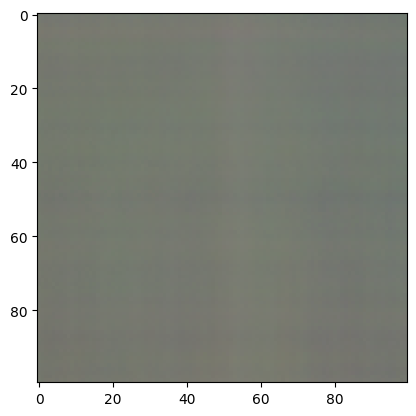

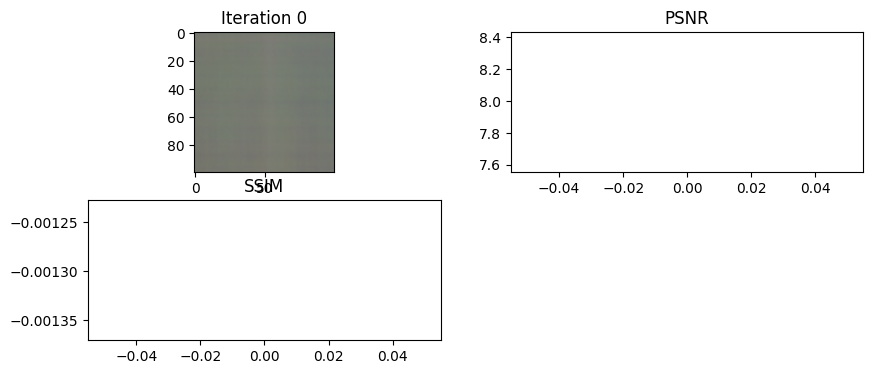

Loss: 0.12999552488327026
Loss: 0.09610963612794876
Loss: 0.08727501332759857
Loss: 0.041431039571762085
Loss: 0.01930609904229641
Loss: 0.044157788157463074
Loss: 0.028167081996798515
Loss: 0.08239558339118958
Loss: 0.07018797099590302
Loss: 0.07332490384578705
Loss: 0.14201225340366364
Loss: 0.11428587883710861
Loss: 0.1145312637090683
Loss: 0.07462579011917114
Loss: 0.09484132379293442
Loss: 0.08520209044218063
Loss: 0.057694051414728165
Loss: 0.029536684975028038
Loss: 0.03783653676509857
Loss: 0.02913345955312252
Loss: 0.062458980828523636
Loss: 0.02389281615614891
Loss: 0.02895054779946804
Loss: 0.059979695826768875
Loss: 0.028838440775871277
Loss: 0.02870248816907406
Loss: 0.14469926059246063
Loss: 0.040379349142313004
Loss: 0.10025253891944885
Loss: 0.0826110690832138
Loss: 0.027320170775055885
Loss: 0.04540865868330002
Loss: 0.07063232362270355
Loss: 0.029642755165696144
Loss: 0.08122006803750992
Loss: 0.11609480530023575
Loss: 0.08421414345502853
Loss: 0.02497924119234085
Los

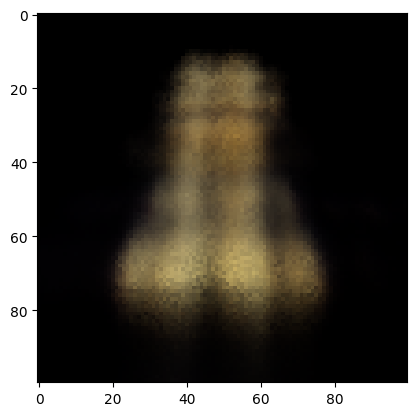

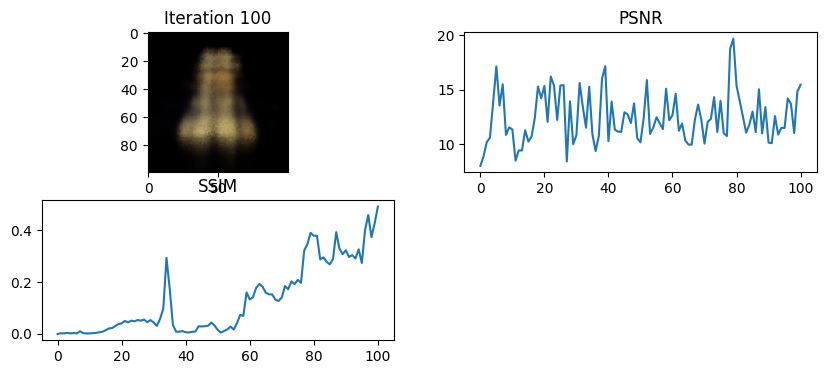

Loss: 0.03684120997786522
Loss: 0.061294034123420715
Loss: 0.0822734609246254
Loss: 0.03296855464577675
Loss: 0.010145129635930061
Loss: 0.04599767550826073
Loss: 0.06682723760604858
Loss: 0.04821689799427986
Loss: 0.0911862924695015
Loss: 0.05588553100824356
Loss: 0.02191084809601307
Loss: 0.06767694652080536
Loss: 0.033900801092386246
Loss: 0.06789245456457138
Loss: 0.08237793296575546
Loss: 0.034624118357896805
Loss: 0.07201092690229416
Loss: 0.06985034048557281
Loss: 0.011093856766819954
Loss: 0.1012621521949768
Loss: 0.04002772644162178
Loss: 0.0915985032916069
Loss: 0.09214334189891815
Loss: 0.022793998941779137
Loss: 0.07134494185447693
Loss: 0.06250154972076416
Loss: 0.016814321279525757
Loss: 0.037767622619867325
Loss: 0.03141398727893829
Loss: 0.030955182388424873
Loss: 0.05878545716404915
Loss: 0.07101216167211533
Loss: 0.061225153505802155
Loss: 0.08029831200838089
Loss: 0.05716855078935623
Loss: 0.08386353403329849
Loss: 0.08391034603118896
Loss: 0.09294423460960388
Loss: 

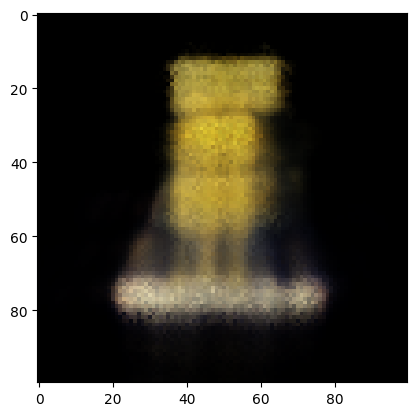

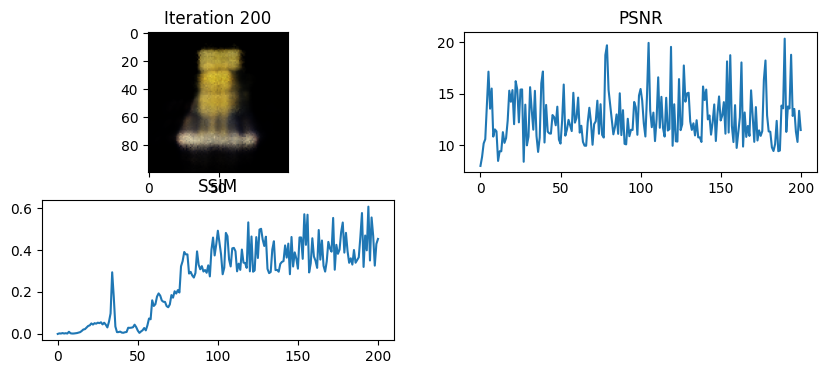

Loss: 0.10593972355127335
Loss: 0.05582178384065628
Loss: 0.04412238672375679
Loss: 0.05445164069533348
Loss: 0.05283346772193909
Loss: 0.05214227735996246
Loss: 0.03395820036530495
Loss: 0.013498889282345772
Loss: 0.024090806022286415
Loss: 0.09296180307865143
Loss: 0.04535228759050369
Loss: 0.025465087965130806
Loss: 0.04353437200188637
Loss: 0.08442850410938263
Loss: 0.059644315391778946
Loss: 0.05020839720964432
Loss: 0.05797998607158661
Loss: 0.044380638748407364
Loss: 0.058064054697752
Loss: 0.08190024644136429
Loss: 0.05161675065755844
Loss: 0.0917116031050682
Loss: 0.07967856526374817
Loss: 0.06349043548107147
Loss: 0.07339967787265778
Loss: 0.06231097877025604
Loss: 0.09195998311042786
Loss: 0.08261319994926453
Loss: 0.04714547097682953
Loss: 0.0838652029633522
Loss: 0.048804622143507004
Loss: 0.05484764650464058
Loss: 0.05034630373120308
Loss: 0.0717366486787796
Loss: 0.1010926216840744
Loss: 0.03145025670528412
Loss: 0.06577426940202713
Loss: 0.04416102170944214
Loss: 0.0807

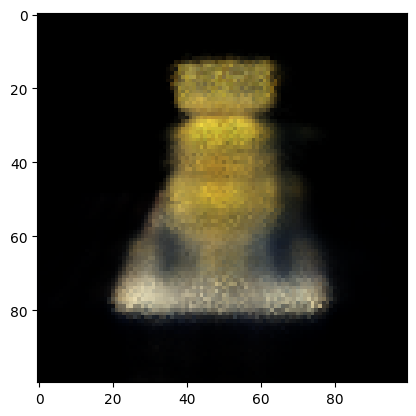

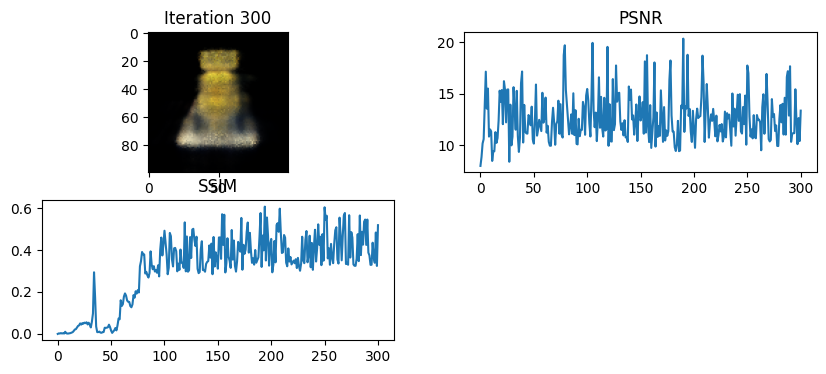

Loss: 0.07672782987356186
Loss: 0.06721984595060349
Loss: 0.056153878569602966
Loss: 0.05222015082836151
Loss: 0.04580976068973541
Loss: 0.0640486627817154
Loss: 0.08479990065097809
Loss: 0.08538264036178589
Loss: 0.0472964346408844
Loss: 0.04676239937543869
Loss: 0.10112033039331436
Loss: 0.042618487030267715
Loss: 0.02224626950919628
Loss: 0.021710192784667015
Loss: 0.05681690573692322
Loss: 0.06563723087310791
Loss: 0.056458327919244766
Loss: 0.06099520996212959
Loss: 0.010505188256502151
Loss: 0.09413492679595947
Loss: 0.0932174101471901
Loss: 0.08239968121051788
Loss: 0.034673117101192474
Loss: 0.07888589054346085
Loss: 0.034336157143116
Loss: 0.10393766313791275
Loss: 0.07599309831857681
Loss: 0.041152410209178925
Loss: 0.08572866022586823
Loss: 0.069452203810215
Loss: 0.09247986972332001
Loss: 0.0439598523080349
Loss: 0.03432386368513107
Loss: 0.07743065059185028
Loss: 0.0708129033446312
Loss: 0.09341554343700409
Loss: 0.04225269705057144
Loss: 0.09079806506633759
Loss: 0.052574

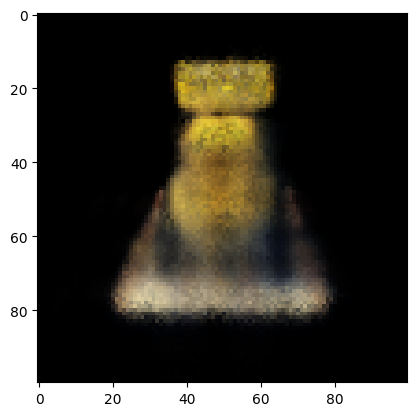

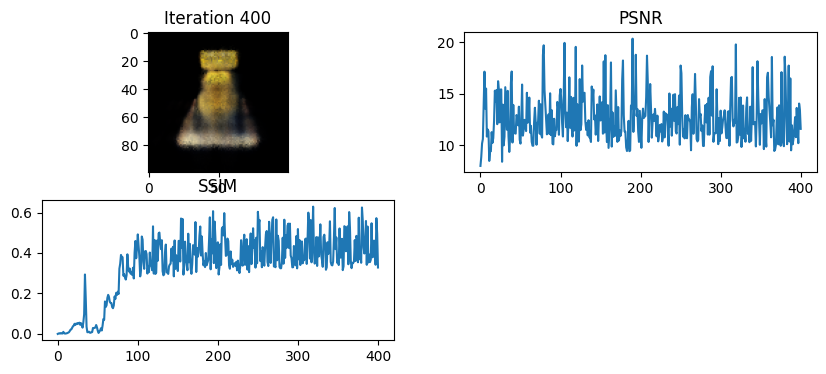

Loss: 0.05499902740120888
Loss: 0.10670271515846252
Loss: 0.09705686569213867
Loss: 0.06664866209030151
Loss: 0.02032790333032608
Loss: 0.10768720507621765
Loss: 0.07079355418682098
Loss: 0.07031343132257462
Loss: 0.09450072795152664
Loss: 0.0832318589091301
Loss: 0.013548335991799831
Loss: 0.07826115190982819
Loss: 0.06982769072055817
Loss: 0.05677732825279236
Loss: 0.08220403641462326
Loss: 0.06075112894177437
Loss: 0.09013183414936066
Loss: 0.049868274480104446
Loss: 0.08746080845594406
Loss: 0.03432182967662811
Loss: 0.09550892561674118
Loss: 0.04972301423549652
Loss: 0.04681640863418579
Loss: 0.09847965836524963
Loss: 0.03172634541988373
Loss: 0.08239766210317612
Loss: 0.019752150401473045
Loss: 0.0820944532752037
Loss: 0.06762176007032394
Loss: 0.04342649504542351
Loss: 0.06597810983657837
Loss: 0.11064755916595459
Loss: 0.05994024500250816
Loss: 0.06347134709358215
Loss: 0.058775894343853
Loss: 0.07856782525777817
Loss: 0.05052095279097557
Loss: 0.024607611820101738
Loss: 0.0631

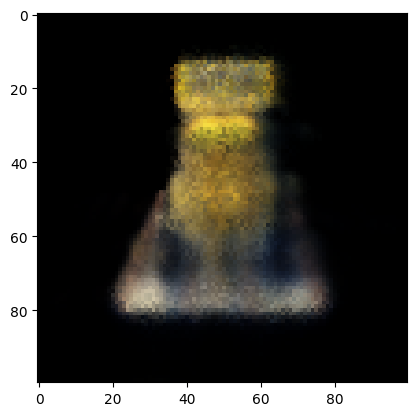

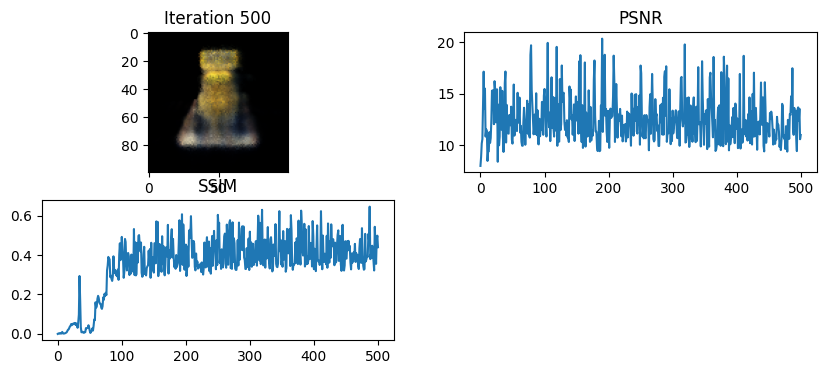

Loss: 0.04877392575144768
Loss: 0.11783181875944138
Loss: 0.10729135572910309
Loss: 0.062382202595472336
Loss: 0.02689681202173233
Loss: 0.0639074519276619
Loss: 0.05180653929710388
Loss: 0.08245102316141129
Loss: 0.059945862740278244
Loss: 0.0849299505352974
Loss: 0.08245917409658432
Loss: 0.022586742416024208
Loss: 0.07874949276447296
Loss: 0.08209239691495895
Loss: 0.05331122502684593
Loss: 0.08736797422170639
Loss: 0.06083311885595322
Loss: 0.015898827463388443
Loss: 0.023271216079592705
Loss: 0.05432124063372612
Loss: 0.08078043907880783
Loss: 0.05102160573005676
Loss: 0.04541536793112755
Loss: 0.01899859681725502
Loss: 0.08552893996238708
Loss: 0.0439193993806839
Loss: 0.04149177297949791
Loss: 0.05373116955161095
Loss: 0.034674182534217834
Loss: 0.07699291408061981
Loss: 0.05050314590334892
Loss: 0.07076152414083481
Loss: 0.0936368778347969
Loss: 0.0891951248049736
Loss: 0.03332913666963577
Loss: 0.032760560512542725
Loss: 0.034958913922309875
Loss: 0.04554855823516846
Loss: 0.0

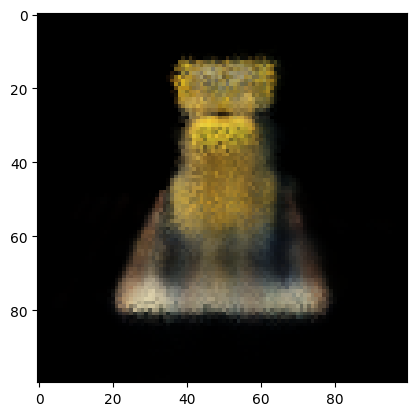

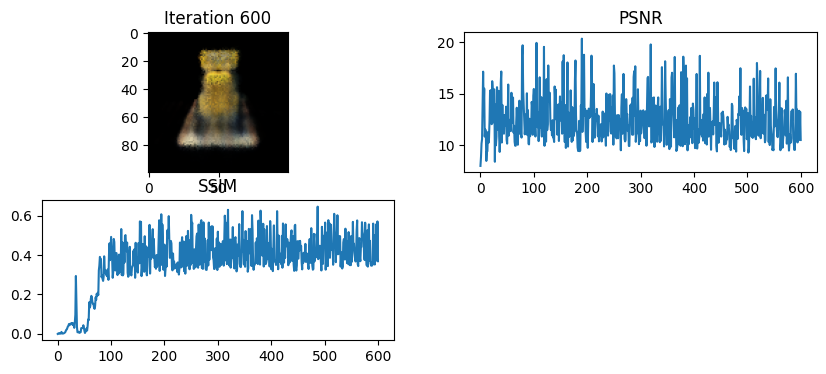

Loss: 0.06746857613325119
Loss: 0.10114232450723648
Loss: 0.052465423941612244
Loss: 0.053808216005563736
Loss: 0.06582598388195038
Loss: 0.08350767195224762
Loss: 0.05633191019296646
Loss: 0.03444497659802437
Loss: 0.09413458406925201
Loss: 0.056980568915605545
Loss: 0.0947323888540268
Loss: 0.0584510937333107
Loss: 0.01234564371407032
Loss: 0.046832792460918427
Loss: 0.03628350794315338
Loss: 0.04661320149898529
Loss: 0.042379096150398254
Loss: 0.06701964139938354
Loss: 0.08121971040964127
Loss: 0.04488096758723259
Loss: 0.03581623360514641
Loss: 0.016932716593146324
Loss: 0.09954991936683655
Loss: 0.05911906063556671
Loss: 0.016109365969896317
Loss: 0.08148843795061111
Loss: 0.0710730031132698
Loss: 0.024223584681749344
Loss: 0.04381265491247177
Loss: 0.07018759101629257
Loss: 0.08578789234161377
Loss: 0.10273214429616928
Loss: 0.08367515355348587
Loss: 0.04516642913222313
Loss: 0.03544071689248085
Loss: 0.058171141892671585
Loss: 0.05618776008486748
Loss: 0.03404318541288376
Loss: 

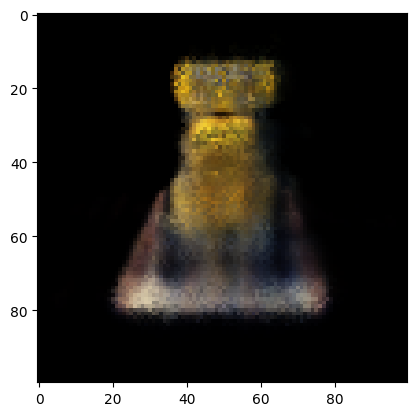

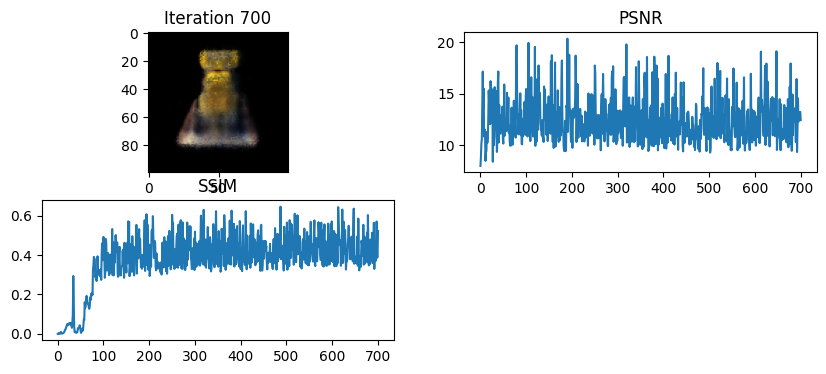

Loss: 0.05012929439544678
Loss: 0.05294287949800491
Loss: 0.023087017238140106
Loss: 0.09787289053201675
Loss: 0.026586271822452545
Loss: 0.08620377629995346
Loss: 0.08291496336460114
Loss: 0.03860661759972572
Loss: 0.034898966550827026
Loss: 0.057748742401599884
Loss: 0.06091928854584694
Loss: 0.05030788853764534
Loss: 0.049264825880527496
Loss: 0.10225182771682739
Loss: 0.08655042201280594
Loss: 0.03412860631942749
Loss: 0.04414549097418785
Loss: 0.07244408130645752
Loss: 0.08314667642116547
Loss: 0.08481454849243164
Loss: 0.04353099688887596
Loss: 0.01723095215857029
Loss: 0.06039676070213318
Loss: 0.0705978199839592
Loss: 0.054436471313238144
Loss: 0.11548393219709396
Loss: 0.07324471324682236
Loss: 0.07314156740903854
Loss: 0.04616982117295265
Loss: 0.03255058825016022
Loss: 0.07739866524934769
Loss: 0.070000059902668
Loss: 0.07508868724107742
Loss: 0.013833588920533657
Loss: 0.05642037093639374
Loss: 0.07718973606824875
Loss: 0.07063191384077072
Loss: 0.09350773692131042
Loss: 0.

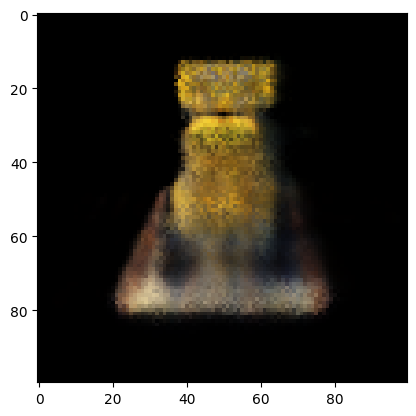

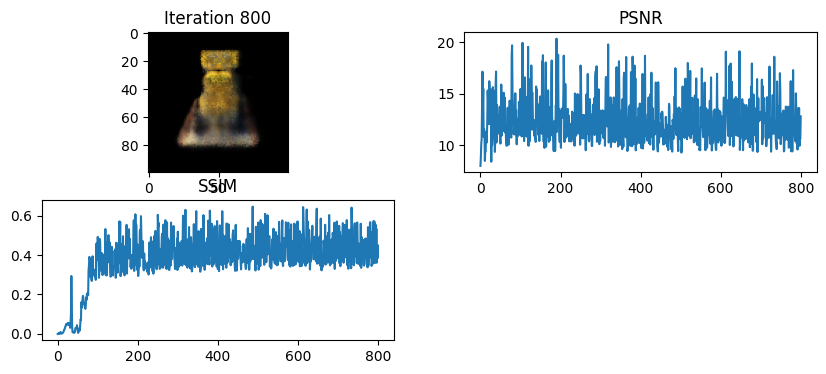

Loss: 0.058546919375658035
Loss: 0.069363534450531
Loss: 0.049607113003730774
Loss: 0.07913282513618469
Loss: 0.07269274443387985
Loss: 0.07182065397500992
Loss: 0.05327025428414345
Loss: 0.06786835938692093
Loss: 0.04800368472933769
Loss: 0.09863992780447006
Loss: 0.09854952991008759
Loss: 0.050336647778749466
Loss: 0.03643651679158211
Loss: 0.021955501288175583
Loss: 0.03318499028682709
Loss: 0.09224367886781693
Loss: 0.09423388540744781
Loss: 0.05614809691905975
Loss: 0.054740242660045624
Loss: 0.1099965050816536
Loss: 0.0886913537979126
Loss: 0.05885018780827522
Loss: 0.06551278382539749
Loss: 0.051620353013277054
Loss: 0.09391245245933533
Loss: 0.04219190776348114
Loss: 0.034396350383758545
Loss: 0.04554228484630585
Loss: 0.043362248688936234
Loss: 0.07724892348051071
Loss: 0.03854050114750862
Loss: 0.0688912644982338
Loss: 0.036413002759218216
Loss: 0.1107063814997673
Loss: 0.05019737780094147
Loss: 0.08466064184904099
Loss: 0.06334645301103592
Loss: 0.09473960101604462
Loss: 0.0

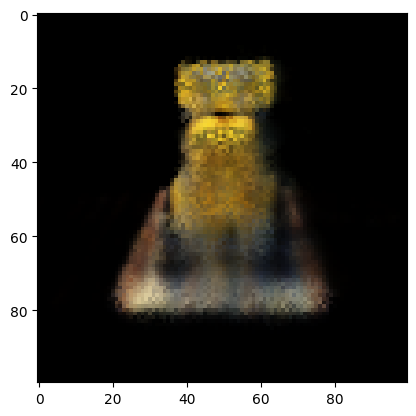

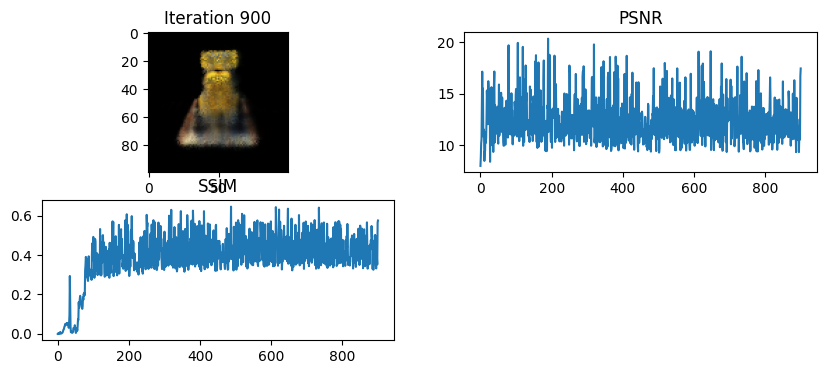

Loss: 0.012270653620362282
Loss: 0.03528549522161484
Loss: 0.05931135267019272
Loss: 0.03542071208357811
Loss: 0.05724707990884781
Loss: 0.06231703981757164
Loss: 0.01765415258705616
Loss: 0.07859582453966141
Loss: 0.10048806667327881
Loss: 0.10454574227333069
Loss: 0.04220897704362869
Loss: 0.047532688826322556
Loss: 0.03715185448527336
Loss: 0.08532439172267914
Loss: 0.05830714479088783
Loss: 0.0696152001619339
Loss: 0.04935208335518837
Loss: 0.0767199844121933
Loss: 0.08252785354852676
Loss: 0.05884560942649841
Loss: 0.07176968455314636
Loss: 0.0570775531232357
Loss: 0.10888618230819702
Loss: 0.06629572063684464
Loss: 0.08427351713180542
Loss: 0.058380626142024994
Loss: 0.07048957794904709
Loss: 0.06808794289827347
Loss: 0.0438137948513031
Loss: 0.04108069837093353
Loss: 0.06319567561149597
Loss: 0.1140354573726654
Loss: 0.03640160337090492
Loss: 0.019092081114649773
Loss: 0.03400546312332153
Loss: 0.05170087516307831
Loss: 0.08210506290197372
Loss: 0.08143968135118484
Loss: 0.07495

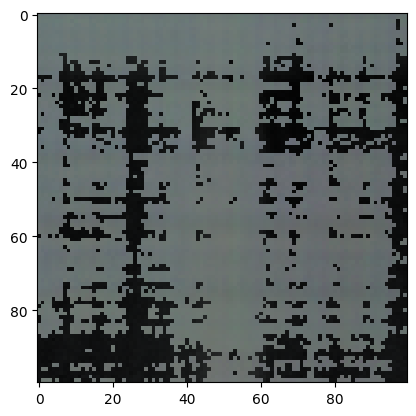

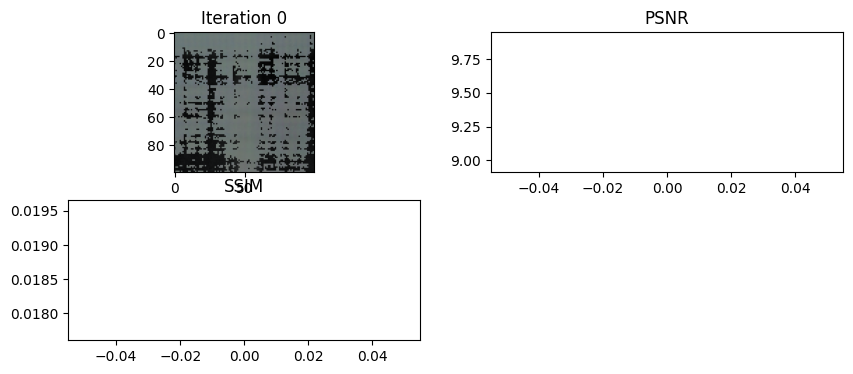

Loss: 0.13621161878108978
Loss: 0.11288716644048691
Loss: 0.08531251549720764
Loss: 0.11180873960256577
Loss: 0.027231117710471153
Loss: 0.06989686191082001
Loss: 0.060346875339746475
Loss: 0.07284823060035706
Loss: 0.05505625903606415
Loss: 0.12137596309185028
Loss: 0.11932592839002609
Loss: 0.12647941708564758
Loss: 0.04685446619987488
Loss: 0.06777863204479218
Loss: 0.04708229750394821
Loss: 0.07916852086782455
Loss: 0.034618716686964035
Loss: 0.0564563013613224
Loss: 0.09717413783073425
Loss: 0.041509825736284256
Loss: 0.1040961742401123
Loss: 0.0867241770029068
Loss: 0.05148063227534294
Loss: 0.10256635397672653
Loss: 0.0564984530210495
Loss: 0.09945464134216309
Loss: 0.08870690315961838
Loss: 0.06824729591608047
Loss: 0.04303238168358803
Loss: 0.03779729828238487
Loss: 0.09820964187383652
Loss: 0.0209956057369709
Loss: 0.03730975091457367
Loss: 0.09471264481544495
Loss: 0.06772632896900177
Loss: 0.04814619570970535
Loss: 0.029095804318785667
Loss: 0.04026259109377861
Loss: 0.0537

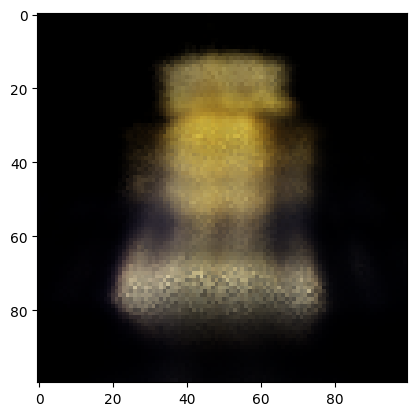

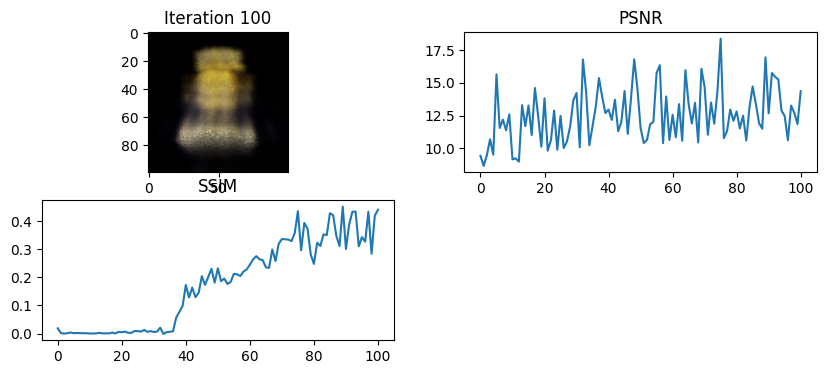

Loss: 0.03551412746310234
Loss: 0.04455417022109032
Loss: 0.07211559265851974
Loss: 0.05410608649253845
Loss: 0.04308686405420303
Loss: 0.07357608526945114
Loss: 0.10529259592294693
Loss: 0.07645680010318756
Loss: 0.0804983451962471
Loss: 0.09560982882976532
Loss: 0.028797192499041557
Loss: 0.09900906682014465
Loss: 0.0880628451704979
Loss: 0.035922225564718246
Loss: 0.05597991868853569
Loss: 0.09694454818964005
Loss: 0.09691645950078964
Loss: 0.06261618435382843
Loss: 0.08696673065423965
Loss: 0.04274892807006836
Loss: 0.01595740020275116
Loss: 0.04180436208844185
Loss: 0.04636001959443092
Loss: 0.0730385035276413
Loss: 0.0809442326426506
Loss: 0.08029958605766296
Loss: 0.03965386003255844
Loss: 0.07407499849796295
Loss: 0.07177722454071045
Loss: 0.05106732249259949
Loss: 0.05070534348487854
Loss: 0.10010077804327011
Loss: 0.05977310240268707
Loss: 0.10693775117397308
Loss: 0.03913525491952896
Loss: 0.0285917017608881
Loss: 0.05558070167899132
Loss: 0.10966627299785614
Loss: 0.0445243

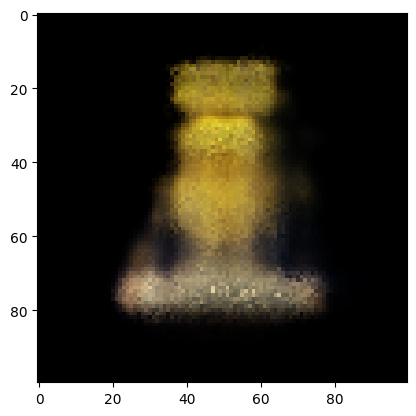

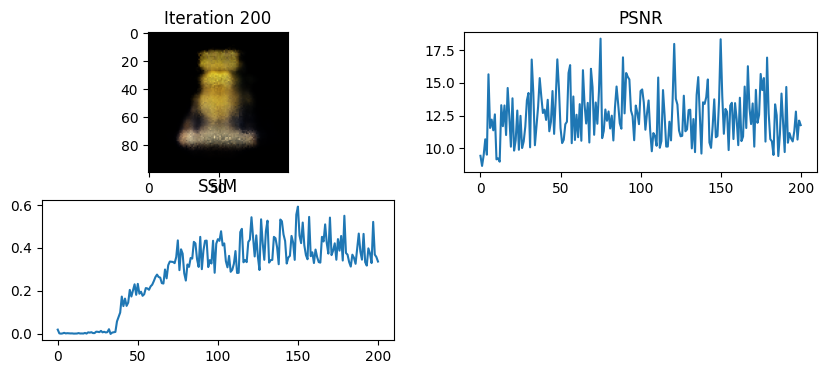

Loss: 0.1000194251537323
Loss: 0.10617218911647797
Loss: 0.09705358743667603
Loss: 0.06577577441930771
Loss: 0.08646126091480255
Loss: 0.07484526187181473
Loss: 0.0792979896068573
Loss: 0.0708407610654831
Loss: 0.027988024055957794
Loss: 0.08663088083267212
Loss: 0.10439512878656387
Loss: 0.029557913541793823
Loss: 0.03438758850097656
Loss: 0.07205135375261307
Loss: 0.1002805083990097
Loss: 0.07717641443014145
Loss: 0.08829847723245621
Loss: 0.06260374188423157
Loss: 0.10904176533222198
Loss: 0.05151573568582535
Loss: 0.082672119140625
Loss: 0.09309294074773788
Loss: 0.0449889600276947
Loss: 0.0801805853843689
Loss: 0.057061679661273956
Loss: 0.0842011496424675
Loss: 0.04989561811089516
Loss: 0.02288459613919258
Loss: 0.04094620794057846
Loss: 0.042619235813617706
Loss: 0.047369927167892456
Loss: 0.08240955322980881
Loss: 0.057891588658094406
Loss: 0.08278678357601166
Loss: 0.09764175117015839
Loss: 0.061167407780885696
Loss: 0.06637653708457947
Loss: 0.10755853354930878
Loss: 0.098768

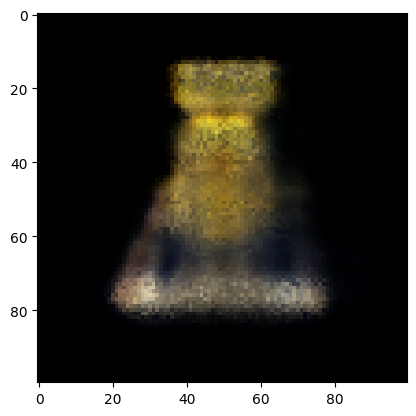

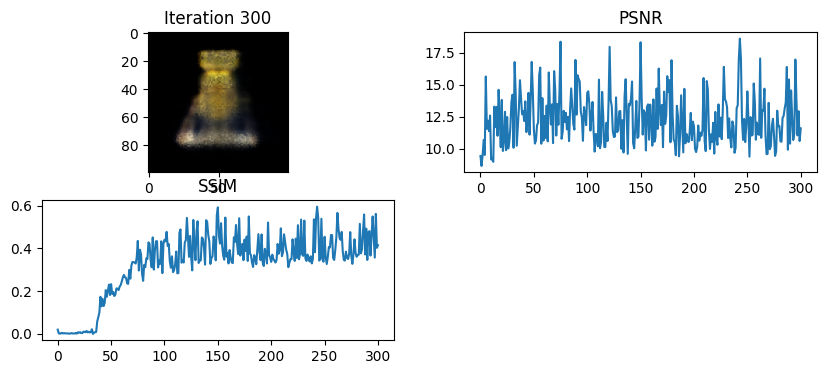

Loss: 0.05961354821920395
Loss: 0.058690525591373444
Loss: 0.07632782310247421
Loss: 0.08157286792993546
Loss: 0.0435042642056942
Loss: 0.056884899735450745
Loss: 0.04399489983916283
Loss: 0.09468165040016174
Loss: 0.06498848646879196
Loss: 0.08530263602733612
Loss: 0.06429386138916016
Loss: 0.09065248817205429
Loss: 0.032874368131160736
Loss: 0.05520620942115784
Loss: 0.09347178041934967
Loss: 0.0684681385755539
Loss: 0.047089286148548126
Loss: 0.047589387744665146
Loss: 0.08513811975717545
Loss: 0.043963391333818436
Loss: 0.045874763280153275
Loss: 0.04166526719927788
Loss: 0.10678707808256149
Loss: 0.03615869954228401
Loss: 0.019537903368473053
Loss: 0.05135884881019592
Loss: 0.09310229122638702
Loss: 0.055701617151498795
Loss: 0.10554788261651993
Loss: 0.10454723238945007
Loss: 0.03518605977296829
Loss: 0.05554146319627762
Loss: 0.042277198284864426
Loss: 0.06279110163450241
Loss: 0.05662839487195015
Loss: 0.09983429312705994
Loss: 0.04502033442258835
Loss: 0.11651133000850677
Loss

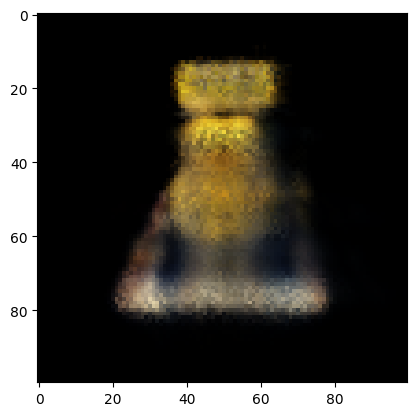

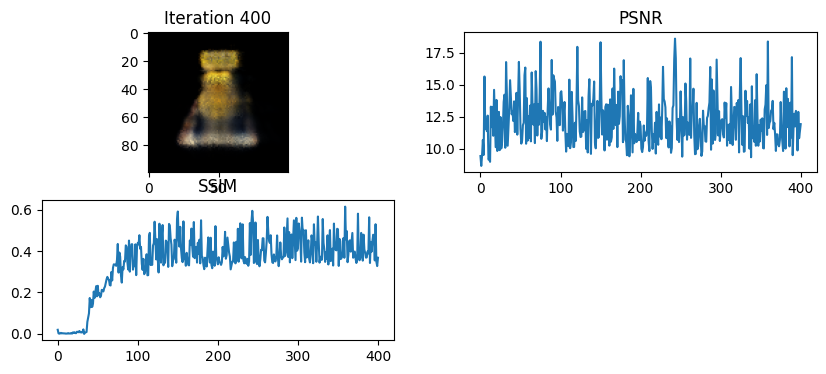

Loss: 0.062312569469213486
Loss: 0.035405199974775314
Loss: 0.03334219381213188
Loss: 0.039791665971279144
Loss: 0.022327536717057228
Loss: 0.05979970470070839
Loss: 0.07958198338747025
Loss: 0.09695445746183395
Loss: 0.07116974145174026
Loss: 0.02800942026078701
Loss: 0.06409554928541183
Loss: 0.05467044189572334
Loss: 0.049250952899456024
Loss: 0.04984688386321068
Loss: 0.10149083286523819
Loss: 0.0464702770113945
Loss: 0.04990873858332634
Loss: 0.08193611353635788
Loss: 0.07896237820386887
Loss: 0.05268317088484764
Loss: 0.035708311945199966
Loss: 0.034572213888168335
Loss: 0.06858474016189575
Loss: 0.10172325372695923
Loss: 0.04675475135445595
Loss: 0.04291241616010666
Loss: 0.09531643986701965
Loss: 0.05755040794610977
Loss: 0.10794699937105179
Loss: 0.05181989073753357
Loss: 0.04463477432727814
Loss: 0.0629960224032402
Loss: 0.0996960699558258
Loss: 0.046200208365917206
Loss: 0.043813642114400864
Loss: 0.09159212559461594
Loss: 0.07739490270614624
Loss: 0.0405438207089901
Loss: 0

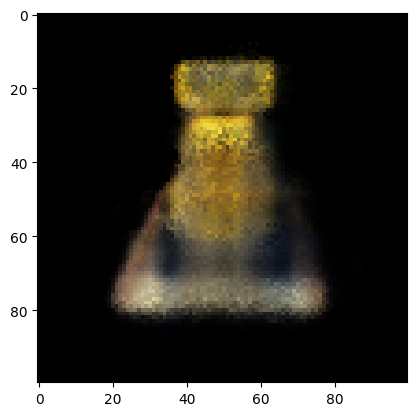

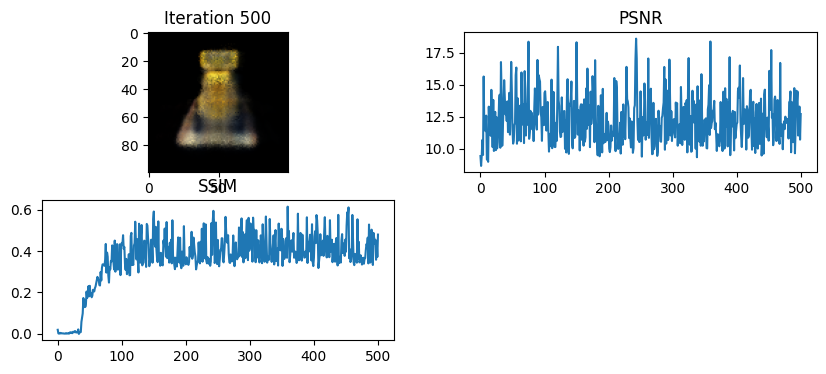

Loss: 0.04238381236791611
Loss: 0.05651681870222092
Loss: 0.05575241521000862
Loss: 0.06727263331413269
Loss: 0.056941885501146317
Loss: 0.0527101494371891
Loss: 0.05608702823519707
Loss: 0.0676567554473877
Loss: 0.08459864556789398
Loss: 0.04861404374241829
Loss: 0.08786893635988235
Loss: 0.10644208639860153
Loss: 0.07682870328426361
Loss: 0.049477118998765945
Loss: 0.056359853595495224
Loss: 0.05674976855516434
Loss: 0.045036401599645615
Loss: 0.060243912041187286
Loss: 0.10779578238725662
Loss: 0.028051359578967094
Loss: 0.08238125592470169
Loss: 0.08201819658279419
Loss: 0.0458541177213192
Loss: 0.11300166696310043
Loss: 0.09314567595720291
Loss: 0.08992669731378555
Loss: 0.05198825150728226
Loss: 0.025436541065573692
Loss: 0.05081525072455406
Loss: 0.10830918699502945
Loss: 0.07029236853122711
Loss: 0.04720863327383995
Loss: 0.06950406730175018
Loss: 0.05762707069516182
Loss: 0.05944937467575073
Loss: 0.054816488176584244
Loss: 0.0887991338968277
Loss: 0.0688098892569542
Loss: 0.0

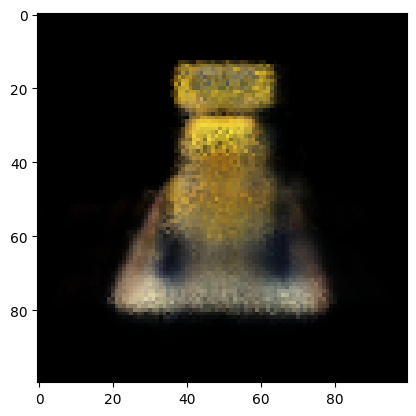

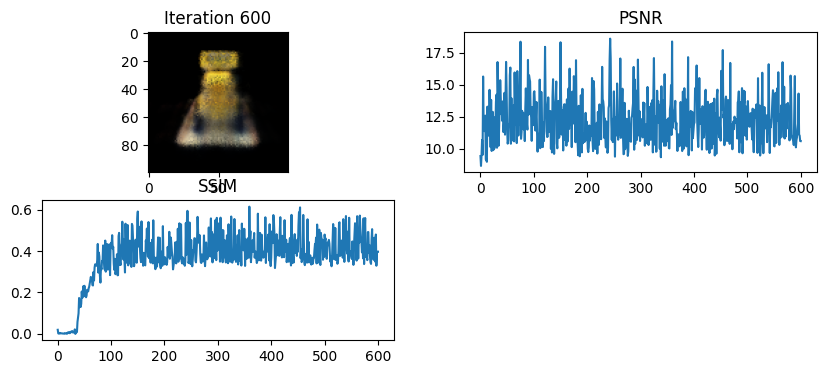

Loss: 0.08628730475902557
Loss: 0.04497228190302849
Loss: 0.09916384518146515
Loss: 0.04138948395848274
Loss: 0.05973488464951515
Loss: 0.059436898678541183
Loss: 0.05437711626291275
Loss: 0.060489505529403687
Loss: 0.08310248702764511
Loss: 0.1103706881403923
Loss: 0.09078336507081985
Loss: 0.07675474137067795
Loss: 0.08289062231779099
Loss: 0.06539640575647354
Loss: 0.08271648734807968
Loss: 0.05845257639884949
Loss: 0.04670301824808121
Loss: 0.020355012267827988
Loss: 0.04802218824625015
Loss: 0.0632997453212738
Loss: 0.05712088942527771
Loss: 0.07022394984960556
Loss: 0.018584348261356354
Loss: 0.059105247259140015
Loss: 0.0893661305308342
Loss: 0.024996202439069748
Loss: 0.03730373457074165
Loss: 0.10103090852499008
Loss: 0.05055912956595421
Loss: 0.058075033128261566
Loss: 0.032628245651721954
Loss: 0.031562644988298416
Loss: 0.029356494545936584
Loss: 0.06487332284450531
Loss: 0.019897326827049255
Loss: 0.08085577934980392
Loss: 0.06922231614589691
Loss: 0.10042776167392731
Loss

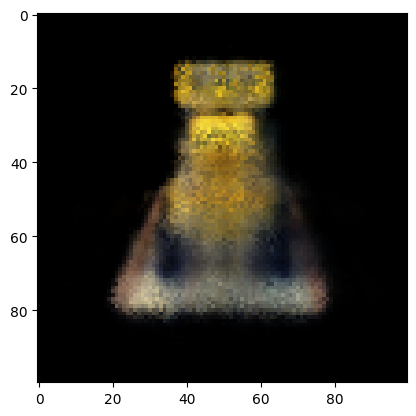

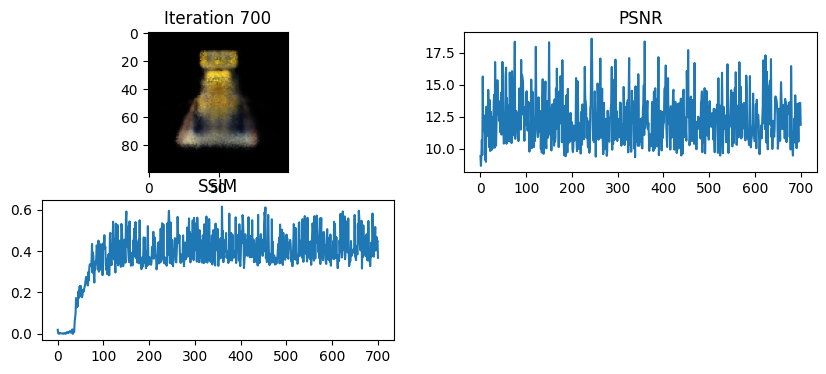

Loss: 0.05539054796099663
Loss: 0.10188384354114532
Loss: 0.01981820911169052
Loss: 0.05443793907761574
Loss: 0.043527018278837204
Loss: 0.03292349353432655
Loss: 0.10573047399520874
Loss: 0.07918449491262436
Loss: 0.05385109782218933
Loss: 0.1149253323674202
Loss: 0.020895391702651978
Loss: 0.035687971860170364
Loss: 0.09428447484970093
Loss: 0.05484529584646225
Loss: 0.0336746945977211
Loss: 0.06029616668820381
Loss: 0.07686031609773636
Loss: 0.08566411584615707
Loss: 0.050205811858177185
Loss: 0.04759543016552925
Loss: 0.07726764678955078
Loss: 0.05240683630108833
Loss: 0.06784678995609283
Loss: 0.028994010761380196
Loss: 0.04863474890589714
Loss: 0.03158130496740341
Loss: 0.07686307281255722
Loss: 0.04781629145145416
Loss: 0.07001004368066788
Loss: 0.11040373891592026
Loss: 0.06508269160985947
Loss: 0.10031165182590485
Loss: 0.10066907852888107
Loss: 0.09765556454658508
Loss: 0.024471018463373184
Loss: 0.09637727588415146
Loss: 0.05910089612007141
Loss: 0.08690998703241348
Loss: 0.

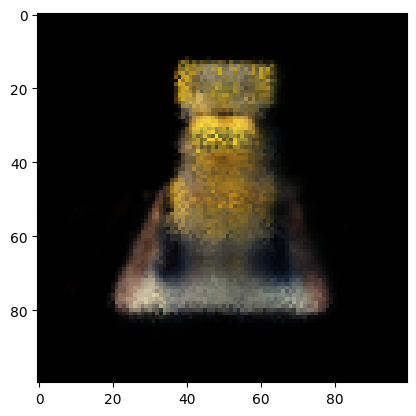

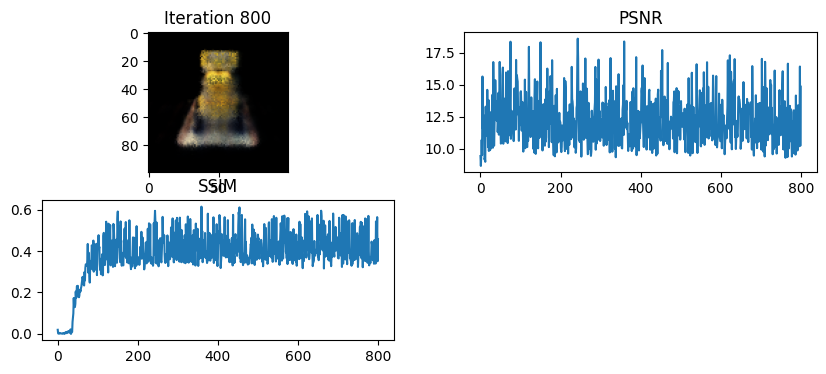

Loss: 0.11387177556753159
Loss: 0.08203495293855667
Loss: 0.04005463048815727
Loss: 0.04809476062655449
Loss: 0.06329743564128876
Loss: 0.10279665887355804
Loss: 0.08169938623905182
Loss: 0.09280281513929367
Loss: 0.046439409255981445
Loss: 0.03828120976686478
Loss: 0.09305048733949661
Loss: 0.10229349136352539
Loss: 0.022048087790608406
Loss: 0.05193415656685829
Loss: 0.09243331849575043
Loss: 0.03459373861551285
Loss: 0.09087303280830383
Loss: 0.05665332451462746
Loss: 0.10176710039377213
Loss: 0.06012507155537605
Loss: 0.06153716519474983
Loss: 0.11048908531665802
Loss: 0.03597462177276611
Loss: 0.04507813975214958
Loss: 0.0453559011220932
Loss: 0.05709844455122948
Loss: 0.06285063922405243
Loss: 0.08495011180639267
Loss: 0.05556255951523781
Loss: 0.07021642476320267
Loss: 0.07909522205591202
Loss: 0.08583661913871765
Loss: 0.030087651684880257
Loss: 0.0978851467370987
Loss: 0.05691080912947655
Loss: 0.046687882393598557
Loss: 0.07997827976942062
Loss: 0.10749250650405884
Loss: 0.08

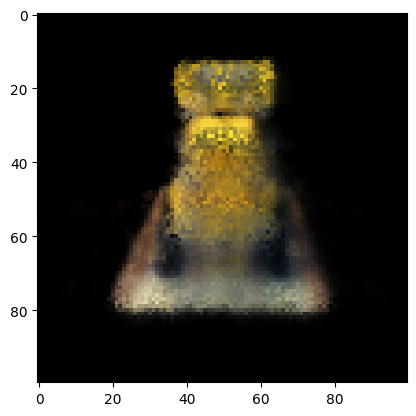

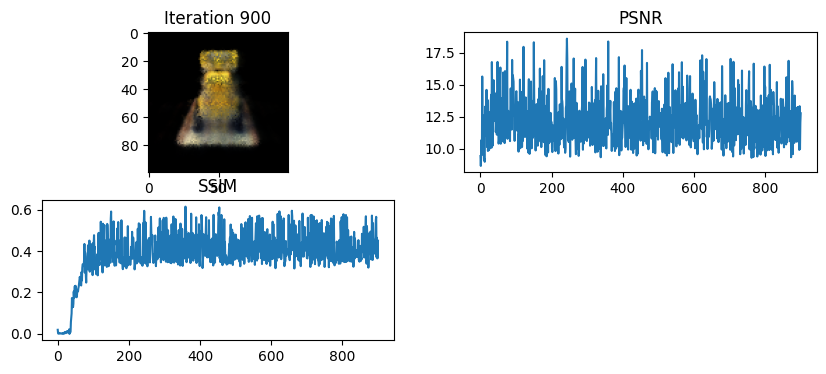

Loss: 0.08026047050952911
Loss: 0.05822852626442909
Loss: 0.04461072012782097
Loss: 0.09812354296445847
Loss: 0.0992995947599411
Loss: 0.06595951318740845
Loss: 0.10176560282707214
Loss: 0.02359495498239994
Loss: 0.06747277081012726
Loss: 0.09572240710258484
Loss: 0.04921000823378563
Loss: 0.06471824645996094
Loss: 0.0465640127658844
Loss: 0.05657539889216423
Loss: 0.07991545647382736
Loss: 0.04962144047021866
Loss: 0.057728756219148636
Loss: 0.056465812027454376
Loss: 0.0829586535692215
Loss: 0.10641895234584808
Loss: 0.07614824175834656
Loss: 0.08383496850728989
Loss: 0.06738936901092529
Loss: 0.06696059554815292
Loss: 0.04433305561542511
Loss: 0.052341215312480927
Loss: 0.047109633684158325
Loss: 0.05954756215214729
Loss: 0.08643202483654022
Loss: 0.05760150030255318
Loss: 0.05329834297299385
Loss: 0.05790857598185539
Loss: 0.037409693002700806
Loss: 0.0858975350856781
Loss: 0.10356838256120682
Loss: 0.06622135639190674
Loss: 0.06890448182821274
Loss: 0.0830564796924591
Loss: 0.0525

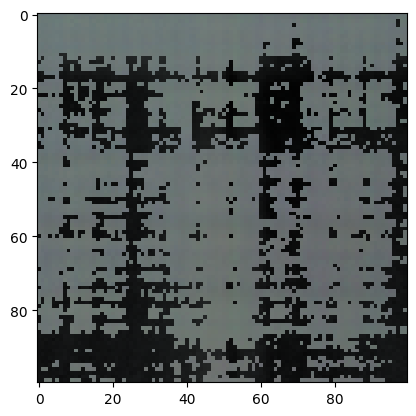

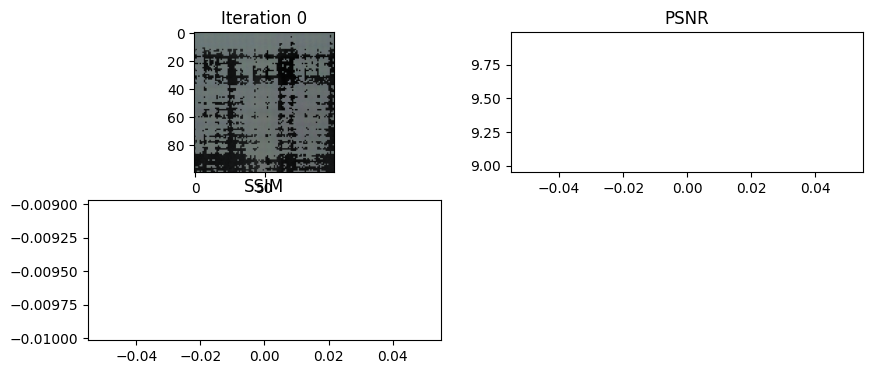

Loss: 0.1125708818435669
Loss: 0.09227239340543747
Loss: 0.0996149331331253
Loss: 0.043375324457883835
Loss: 0.11474741995334625
Loss: 0.06772136688232422
Loss: 0.08173401653766632
Loss: 0.020010286942124367
Loss: 0.07879582792520523
Loss: 0.023519840091466904
Loss: 0.02343163825571537
Loss: 0.1217818558216095
Loss: 0.08106718957424164
Loss: 0.09209927916526794
Loss: 0.04538150876760483
Loss: 0.07698990404605865
Loss: 0.045376695692539215
Loss: 0.06312467157840729
Loss: 0.07216157019138336
Loss: 0.01992204412817955
Loss: 0.06044398248195648
Loss: 0.05514923483133316
Loss: 0.015437719412147999
Loss: 0.06107429042458534
Loss: 0.025597741827368736
Loss: 0.01669755019247532
Loss: 0.07675110548734665
Loss: 0.045098382979631424
Loss: 0.03469088301062584
Loss: 0.09398714452981949
Loss: 0.019627396017313004
Loss: 0.02988080494105816
Loss: 0.049535710364580154
Loss: 0.06408219784498215
Loss: 0.024513782933354378
Loss: 0.03158426284790039
Loss: 0.024042924866080284
Loss: 0.02998506836593151
Loss

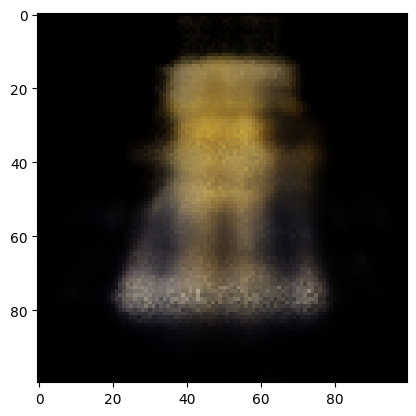

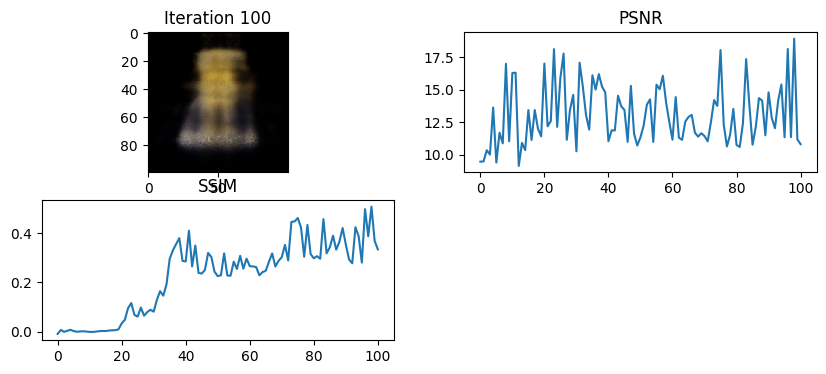

Loss: 0.01553539652377367
Loss: 0.05298801511526108
Loss: 0.10146379470825195
Loss: 0.053846575319767
Loss: 0.08876786381006241
Loss: 0.05727790296077728
Loss: 0.08119237422943115
Loss: 0.08027078211307526
Loss: 0.029342900961637497
Loss: 0.01798645406961441
Loss: 0.07805608958005905
Loss: 0.09302777051925659
Loss: 0.05103125050663948
Loss: 0.03798001632094383
Loss: 0.047286901623010635
Loss: 0.09155550599098206
Loss: 0.08030156046152115
Loss: 0.030008967965841293
Loss: 0.028637731447815895
Loss: 0.03744089603424072
Loss: 0.07965953648090363
Loss: 0.044906895607709885
Loss: 0.0331401526927948
Loss: 0.03128313645720482
Loss: 0.09124357998371124
Loss: 0.0657496526837349
Loss: 0.060760583728551865
Loss: 0.08172430843114853
Loss: 0.03662167489528656
Loss: 0.03841165080666542
Loss: 0.08295205235481262
Loss: 0.03404594585299492
Loss: 0.055913232266902924
Loss: 0.018174707889556885
Loss: 0.09318750351667404
Loss: 0.06764890998601913
Loss: 0.10202005505561829
Loss: 0.017509566619992256
Loss: 0

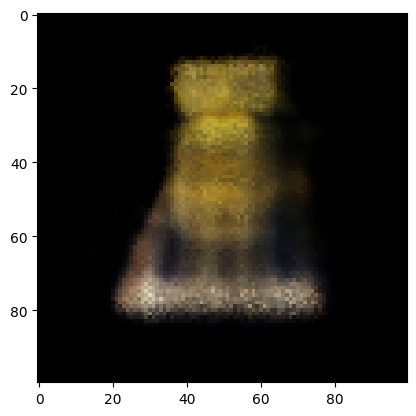

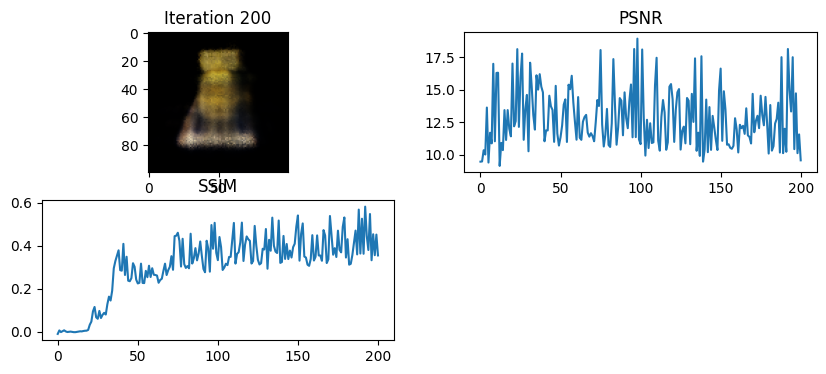

Loss: 0.07667241245508194
Loss: 0.09764710813760757
Loss: 0.04550163447856903
Loss: 0.08617696911096573
Loss: 0.09373782575130463
Loss: 0.055441632866859436
Loss: 0.10048875957727432
Loss: 0.08649622648954391
Loss: 0.024328365921974182
Loss: 0.06656841933727264
Loss: 0.04454527050256729
Loss: 0.04976850003004074
Loss: 0.08070780336856842
Loss: 0.09255016595125198
Loss: 0.09865090996026993
Loss: 0.05283455550670624
Loss: 0.09195086359977722
Loss: 0.035218846052885056
Loss: 0.08040700852870941
Loss: 0.0633409395813942
Loss: 0.044347938150167465
Loss: 0.09810309112071991
Loss: 0.06619874387979507
Loss: 0.019918343052268028
Loss: 0.07646504789590836
Loss: 0.07681451737880707
Loss: 0.05981331318616867
Loss: 0.043151188641786575
Loss: 0.07011174410581589
Loss: 0.04129006713628769
Loss: 0.07933671027421951
Loss: 0.07934939116239548
Loss: 0.05630972236394882
Loss: 0.053402625024318695
Loss: 0.10059557110071182
Loss: 0.0722515881061554
Loss: 0.03434906527400017
Loss: 0.10211808234453201
Loss: 0

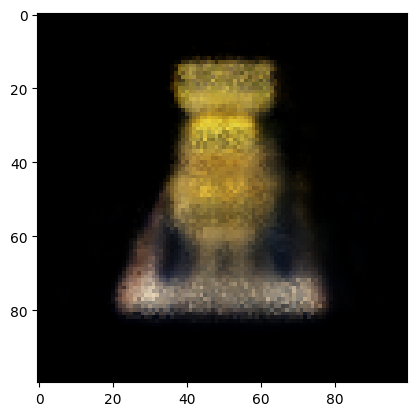

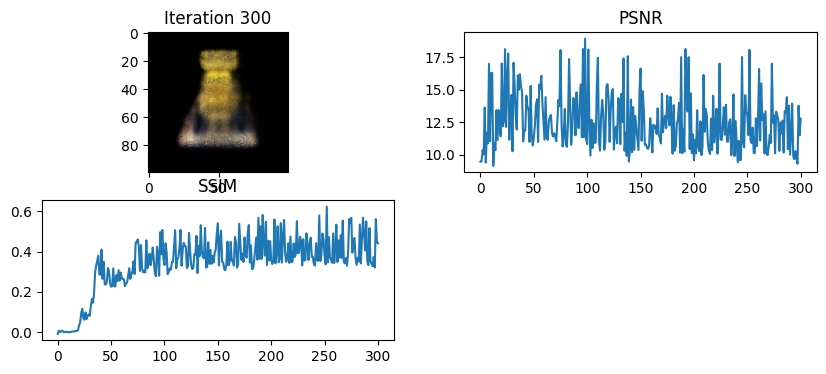

Loss: 0.080579474568367
Loss: 0.09336798638105392
Loss: 0.07402977347373962
Loss: 0.09319773316383362
Loss: 0.04398662969470024
Loss: 0.06134698539972305
Loss: 0.08924435824155807
Loss: 0.057855766266584396
Loss: 0.07507603615522385
Loss: 0.09442688524723053
Loss: 0.05400589853525162
Loss: 0.06362216919660568
Loss: 0.04736265912652016
Loss: 0.0922926664352417
Loss: 0.05639499053359032
Loss: 0.020979823544621468
Loss: 0.0983186587691307
Loss: 0.05319808050990105
Loss: 0.07158993184566498
Loss: 0.059153661131858826
Loss: 0.046638697385787964
Loss: 0.03604107350111008
Loss: 0.0735073983669281
Loss: 0.08134112507104874
Loss: 0.0873909518122673
Loss: 0.04286912456154823
Loss: 0.0868544951081276
Loss: 0.05734455958008766
Loss: 0.048353418707847595
Loss: 0.06913631409406662
Loss: 0.1079925149679184
Loss: 0.04715714231133461
Loss: 0.08107899874448776
Loss: 0.10164227336645126
Loss: 0.10343267768621445
Loss: 0.05638115480542183
Loss: 0.09373950958251953
Loss: 0.01977519504725933
Loss: 0.0177526

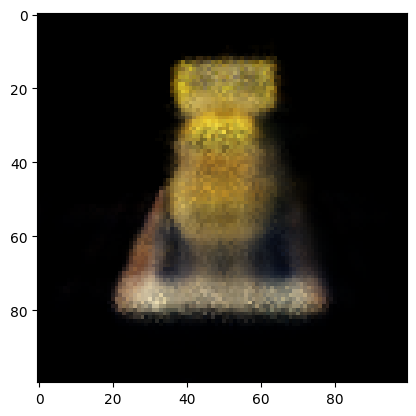

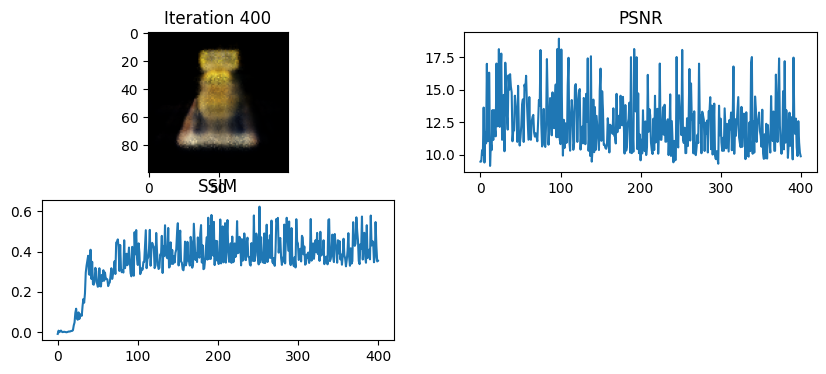

Loss: 0.04245792329311371
Loss: 0.048145752400159836
Loss: 0.0582159161567688
Loss: 0.045569807291030884
Loss: 0.07873702794313431
Loss: 0.019639259204268456
Loss: 0.02035892754793167
Loss: 0.10906141251325607
Loss: 0.06156019866466522
Loss: 0.05642588809132576
Loss: 0.0926053449511528
Loss: 0.06479769200086594
Loss: 0.06878199428319931
Loss: 0.04166927933692932
Loss: 0.05856538936495781
Loss: 0.09350062906742096
Loss: 0.06318005174398422
Loss: 0.09403915703296661
Loss: 0.10046005249023438
Loss: 0.09999191761016846
Loss: 0.035039085894823074
Loss: 0.06582390516996384
Loss: 0.09758800268173218
Loss: 0.04585203528404236
Loss: 0.10835196822881699
Loss: 0.09413744509220123
Loss: 0.033621519804000854
Loss: 0.09224618226289749
Loss: 0.05144190043210983
Loss: 0.03505241125822067
Loss: 0.052702758461236954
Loss: 0.03490838780999184
Loss: 0.043864503502845764
Loss: 0.06732384115457535
Loss: 0.09152150899171829
Loss: 0.07130195200443268
Loss: 0.052642449736595154
Loss: 0.08667320013046265
Loss: 

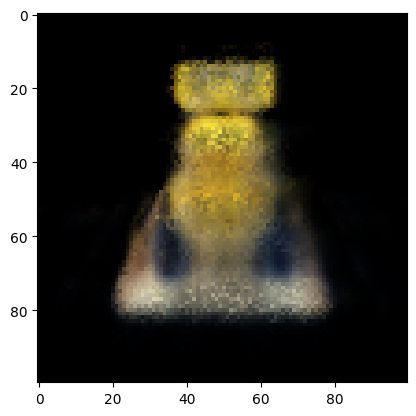

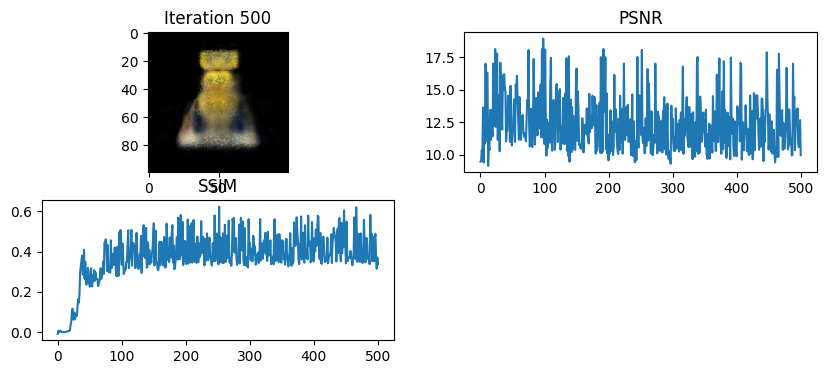

Loss: 0.04782133921980858
Loss: 0.0329708606004715
Loss: 0.042989835143089294
Loss: 0.055797021836042404
Loss: 0.05966811999678612
Loss: 0.053700584918260574
Loss: 0.07217253744602203
Loss: 0.053699787706136703
Loss: 0.10284210741519928
Loss: 0.0949142649769783
Loss: 0.05290112644433975
Loss: 0.044024959206581116
Loss: 0.09383732080459595
Loss: 0.09802574664354324
Loss: 0.11512141674757004
Loss: 0.09361883997917175
Loss: 0.052004098892211914
Loss: 0.03538518026471138
Loss: 0.052297741174697876
Loss: 0.04461265355348587
Loss: 0.08610718697309494
Loss: 0.09966719895601273
Loss: 0.07049528509378433
Loss: 0.03910825774073601
Loss: 0.04901115223765373
Loss: 0.07981227338314056
Loss: 0.022126462310552597
Loss: 0.09869194030761719
Loss: 0.10304174572229385
Loss: 0.05829521641135216
Loss: 0.05670350044965744
Loss: 0.06063368171453476
Loss: 0.09839832037687302
Loss: 0.08316254615783691
Loss: 0.10306772589683533
Loss: 0.04481135681271553
Loss: 0.023177646100521088
Loss: 0.08432931452989578
Loss:

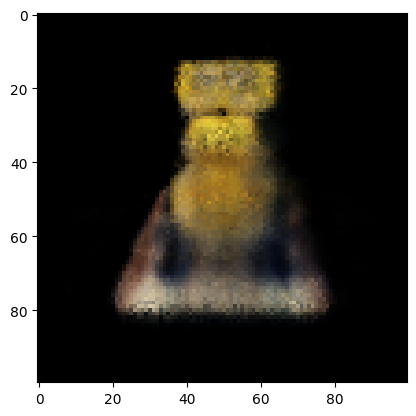

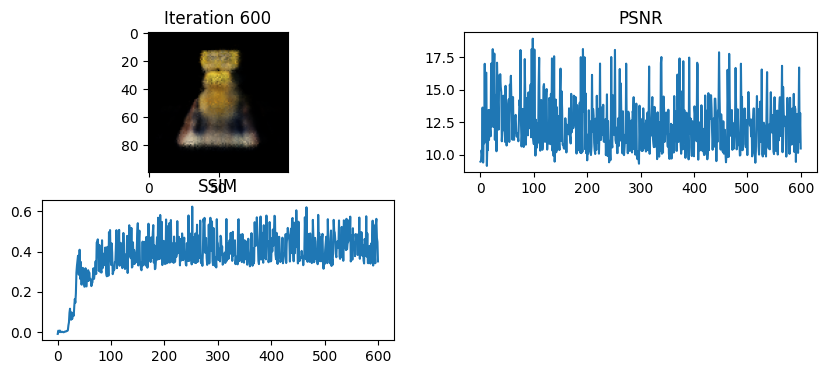

Loss: 0.05256950855255127
Loss: 0.08523697406053543
Loss: 0.04722565412521362
Loss: 0.07829241454601288
Loss: 0.04905765503644943
Loss: 0.05313308164477348
Loss: 0.048526450991630554
Loss: 0.057553231716156006
Loss: 0.11454979330301285
Loss: 0.061618413776159286
Loss: 0.04633498191833496
Loss: 0.054635293781757355
Loss: 0.04223779961466789
Loss: 0.0780034214258194
Loss: 0.05101851746439934
Loss: 0.02224954403936863
Loss: 0.04586381837725639
Loss: 0.08605103194713593
Loss: 0.05170147120952606
Loss: 0.07162292301654816
Loss: 0.09883242845535278
Loss: 0.03393051028251648
Loss: 0.054747484624385834
Loss: 0.09298674762248993
Loss: 0.07149748504161835
Loss: 0.043966080993413925
Loss: 0.08130884915590286
Loss: 0.05585648864507675
Loss: 0.10699909925460815
Loss: 0.056826718151569366
Loss: 0.08837486058473587
Loss: 0.03618251532316208
Loss: 0.05698089301586151
Loss: 0.10686979442834854
Loss: 0.10657382011413574
Loss: 0.06639516353607178
Loss: 0.04456068202853203
Loss: 0.05197277292609215
Loss: 

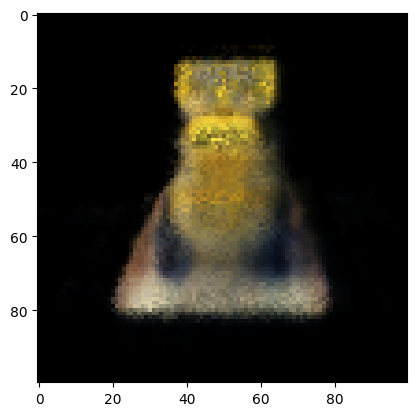

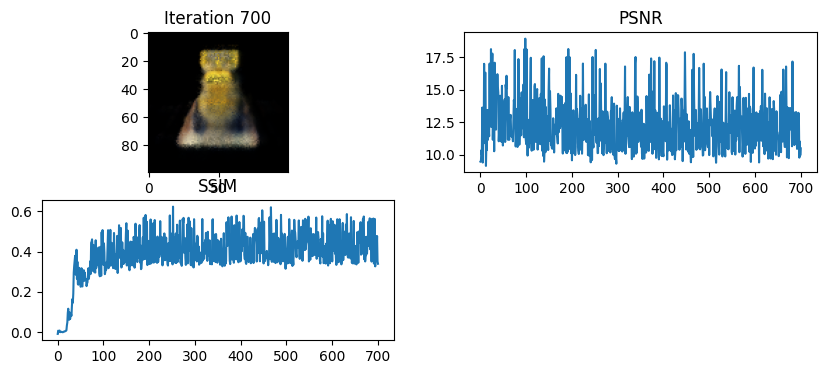

Loss: 0.09414087980985641
Loss: 0.06004421412944794
Loss: 0.06148292496800423
Loss: 0.07036330550909042
Loss: 0.07936834543943405
Loss: 0.07379285991191864
Loss: 0.1122133731842041
Loss: 0.0431399792432785
Loss: 0.02435603179037571
Loss: 0.04425155371427536
Loss: 0.10606145858764648
Loss: 0.034621160477399826
Loss: 0.11139451712369919
Loss: 0.09620284289121628
Loss: 0.019978491589426994
Loss: 0.09369585663080215
Loss: 0.04087069630622864
Loss: 0.051071956753730774
Loss: 0.0384511761367321
Loss: 0.054419972002506256
Loss: 0.05522044375538826
Loss: 0.05263814330101013
Loss: 0.03425253927707672
Loss: 0.10489079356193542
Loss: 0.05401858687400818
Loss: 0.10872522741556168
Loss: 0.09211327880620956
Loss: 0.09412461519241333
Loss: 0.04630941525101662
Loss: 0.09291135519742966
Loss: 0.030016964301466942
Loss: 0.03861653804779053
Loss: 0.05988910794258118
Loss: 0.09625620394945145
Loss: 0.05168759077787399
Loss: 0.10822251439094543
Loss: 0.1170780211687088
Loss: 0.0708458200097084
Loss: 0.0537

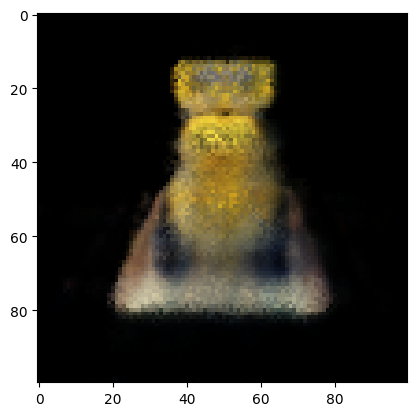

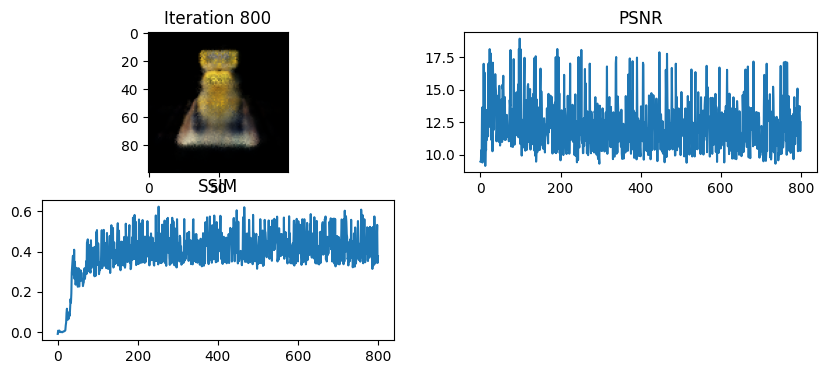

Loss: 0.050002288073301315
Loss: 0.0340740792453289
Loss: 0.07934106141328812
Loss: 0.05905226990580559
Loss: 0.04572880268096924
Loss: 0.07980311661958694
Loss: 0.08446290343999863
Loss: 0.09656934440135956
Loss: 0.06637724488973618
Loss: 0.08213479816913605
Loss: 0.08714725822210312
Loss: 0.038667675107717514
Loss: 0.06879211962223053
Loss: 0.11551065742969513
Loss: 0.08248086273670197
Loss: 0.10389543324708939
Loss: 0.08327779918909073
Loss: 0.08924943208694458
Loss: 0.09593193233013153
Loss: 0.08274028450250626
Loss: 0.02437795139849186
Loss: 0.1111120954155922
Loss: 0.04661483317613602
Loss: 0.046748802065849304
Loss: 0.08989676088094711
Loss: 0.04482990875840187
Loss: 0.03477508947253227
Loss: 0.04647368937730789
Loss: 0.08425518125295639
Loss: 0.01730962097644806
Loss: 0.033723730593919754
Loss: 0.08438057452440262
Loss: 0.08361531794071198
Loss: 0.06329675763845444
Loss: 0.09986259788274765
Loss: 0.07800599932670593
Loss: 0.04641259089112282
Loss: 0.05306405574083328
Loss: 0.09

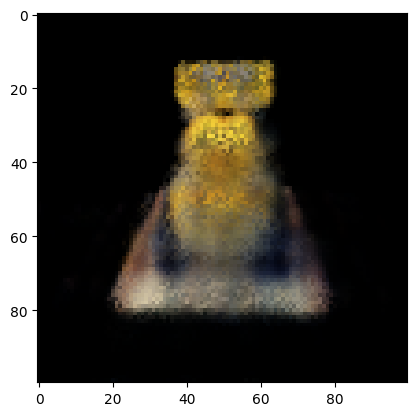

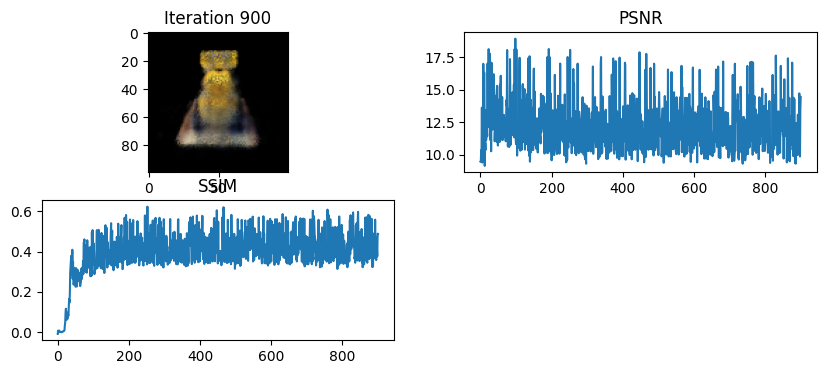

Loss: 0.07808849215507507
Loss: 0.05803448334336281
Loss: 0.04840759560465813
Loss: 0.056725140661001205
Loss: 0.08771088719367981
Loss: 0.06094254180788994
Loss: 0.10689931362867355
Loss: 0.050937749445438385
Loss: 0.09612425416707993
Loss: 0.034618671983480453
Loss: 0.10044954717159271
Loss: 0.06484558433294296
Loss: 0.09645580500364304
Loss: 0.0829324945807457
Loss: 0.04597989097237587
Loss: 0.07390312850475311
Loss: 0.08372721076011658
Loss: 0.10409525036811829
Loss: 0.05128958076238632
Loss: 0.04422468692064285
Loss: 0.021559370681643486
Loss: 0.08441605418920517
Loss: 0.03534994646906853
Loss: 0.04869895055890083
Loss: 0.0872870460152626
Loss: 0.06576452404260635
Loss: 0.059067822992801666
Loss: 0.0954306498169899
Loss: 0.0196115430444479
Loss: 0.01771514117717743
Loss: 0.059571996331214905
Loss: 0.0792907252907753
Loss: 0.05210382863879204
Loss: 0.06298740953207016
Loss: 0.06891312450170517
Loss: 0.06904013454914093
Loss: 0.016489464789628983
Loss: 0.05570124462246895
Loss: 0.11

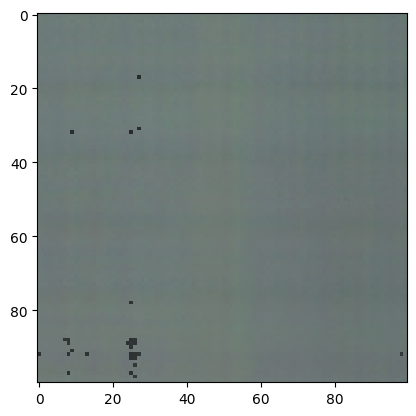

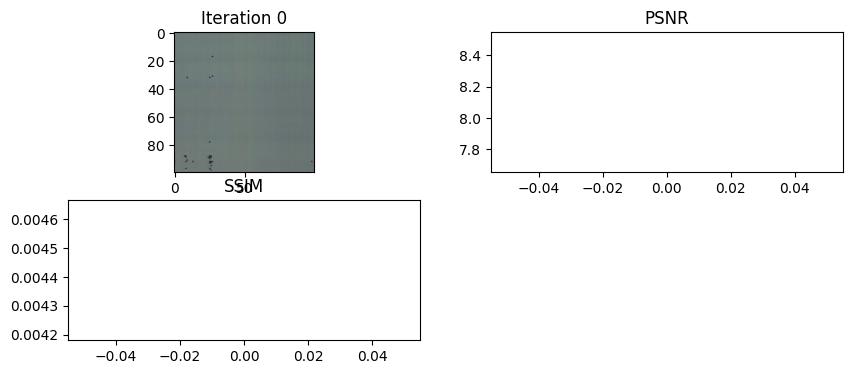

Loss: 0.0977289080619812
Loss: 0.0739995688199997
Loss: 0.10340510308742523
Loss: 0.03694365173578262
Loss: 0.09384386241436005
Loss: 0.074457086622715
Loss: 0.024290872737765312
Loss: 0.018930576741695404
Loss: 0.0640338882803917
Loss: 0.06448174268007278
Loss: 0.06489287316799164
Loss: 0.040751487016677856
Loss: 0.024249926209449768
Loss: 0.04731292650103569
Loss: 0.04077228531241417
Loss: 0.08326736837625504
Loss: 0.06185372173786163
Loss: 0.06232441961765289
Loss: 0.07990086823701859
Loss: 0.0751752257347107
Loss: 0.058727018535137177
Loss: 0.04255889728665352
Loss: 0.057172950357198715
Loss: 0.08725976198911667
Loss: 0.03903321921825409
Loss: 0.03426424413919449
Loss: 0.038259975612163544
Loss: 0.05475011095404625
Loss: 0.018634172156453133
Loss: 0.03761886805295944
Loss: 0.06735397130250931
Loss: 0.03012746572494507
Loss: 0.032897911965847015
Loss: 0.04761695861816406
Loss: 0.0620744489133358
Loss: 0.0659637376666069
Loss: 0.062414877116680145
Loss: 0.051188934594392776
Loss: 0.0

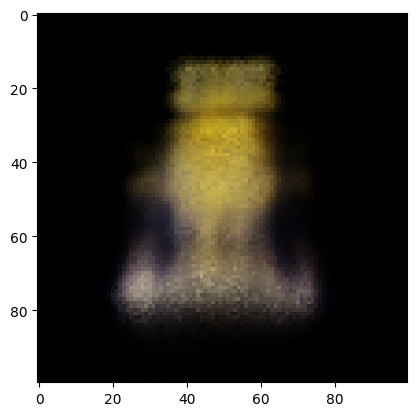

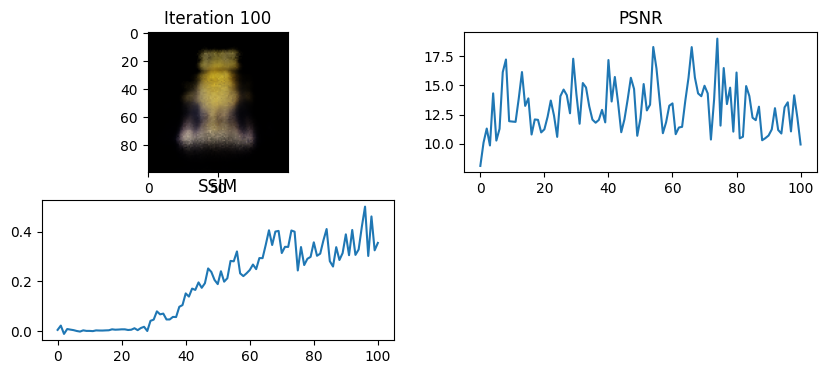

Loss: 0.10014831274747849
Loss: 0.07826549559831619
Loss: 0.020474668592214584
Loss: 0.03337807580828667
Loss: 0.08581839501857758
Loss: 0.05648497864603996
Loss: 0.041313815861940384
Loss: 0.10362985730171204
Loss: 0.07750663161277771
Loss: 0.09795265644788742
Loss: 0.06160619482398033
Loss: 0.08163867145776749
Loss: 0.10060638189315796
Loss: 0.06958281248807907
Loss: 0.03238358348608017
Loss: 0.03818729892373085
Loss: 0.08070021122694016
Loss: 0.052430812269449234
Loss: 0.0610666498541832
Loss: 0.04451755806803703
Loss: 0.07387031614780426
Loss: 0.06498470157384872
Loss: 0.08659357577562332
Loss: 0.09229253977537155
Loss: 0.08838065713644028
Loss: 0.049189209938049316
Loss: 0.03469179943203926
Loss: 0.08841808140277863
Loss: 0.057138942182064056
Loss: 0.05641000717878342
Loss: 0.09186580032110214
Loss: 0.05702963471412659
Loss: 0.056288041174411774
Loss: 0.010159122757613659
Loss: 0.0813342034816742
Loss: 0.08253815025091171
Loss: 0.09812036156654358
Loss: 0.022680319845676422
Loss: 

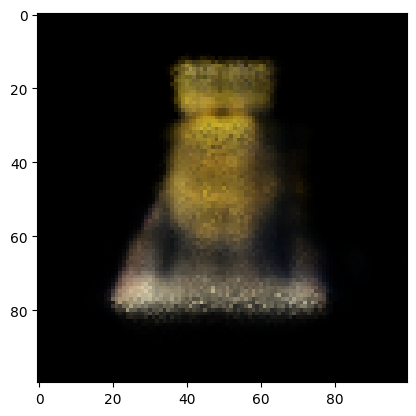

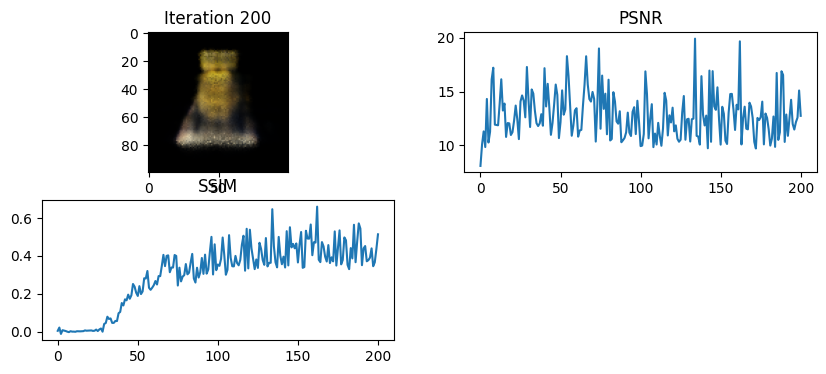

Loss: 0.019954832270741463
Loss: 0.07758721709251404
Loss: 0.07557617872953415
Loss: 0.04470665752887726
Loss: 0.059099528938531876
Loss: 0.05610336735844612
Loss: 0.0428619459271431
Loss: 0.03350871428847313
Loss: 0.0330820269882679
Loss: 0.04357185959815979
Loss: 0.08283033221960068
Loss: 0.0778195858001709
Loss: 0.018002035096287727
Loss: 0.09479226917028427
Loss: 0.031220516189932823
Loss: 0.04839896783232689
Loss: 0.049465104937553406
Loss: 0.018007447943091393
Loss: 0.07536709308624268
Loss: 0.07557733356952667
Loss: 0.09864553809165955
Loss: 0.0703219547867775
Loss: 0.1088775098323822
Loss: 0.06619137525558472
Loss: 0.08707712590694427
Loss: 0.08838698267936707
Loss: 0.05115935951471329
Loss: 0.0553726889193058
Loss: 0.052485108375549316
Loss: 0.045668359845876694
Loss: 0.0645284429192543
Loss: 0.0571516714990139
Loss: 0.056614287197589874
Loss: 0.020658200606703758
Loss: 0.087644062936306
Loss: 0.022090576589107513
Loss: 0.07065382599830627
Loss: 0.04242140054702759
Loss: 0.044

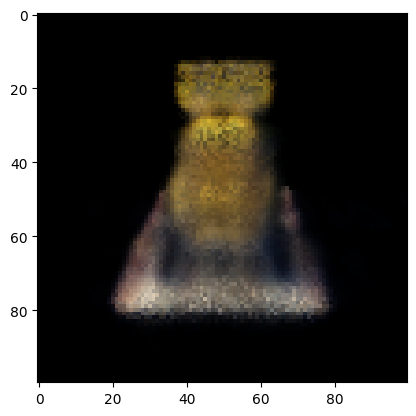

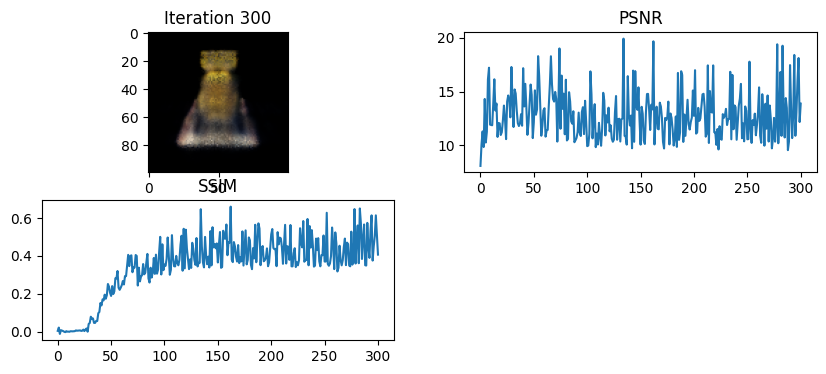

Loss: 0.039747204631567
Loss: 0.05243312567472458
Loss: 0.050971921533346176
Loss: 0.08299945294857025
Loss: 0.06538813561201096
Loss: 0.08575952798128128
Loss: 0.06849353015422821
Loss: 0.04494436830282211
Loss: 0.04583410918712616
Loss: 0.038988471031188965
Loss: 0.10091029107570648
Loss: 0.11125807464122772
Loss: 0.05878720059990883
Loss: 0.056905534118413925
Loss: 0.03240193799138069
Loss: 0.05886714532971382
Loss: 0.01682429388165474
Loss: 0.061445433646440506
Loss: 0.0174065213650465
Loss: 0.055873479694128036
Loss: 0.09615777432918549
Loss: 0.07034514844417572
Loss: 0.08820460736751556
Loss: 0.06779889017343521
Loss: 0.09867363423109055
Loss: 0.04088125377893448
Loss: 0.09339065849781036
Loss: 0.023473989218473434
Loss: 0.08393476903438568
Loss: 0.07989931851625443
Loss: 0.066231369972229
Loss: 0.04248581454157829
Loss: 0.05711742863059044
Loss: 0.04828674718737602
Loss: 0.0811152309179306
Loss: 0.051401037722826004
Loss: 0.06867467612028122
Loss: 0.09252670407295227
Loss: 0.032

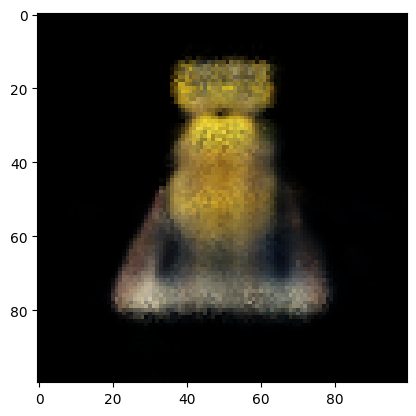

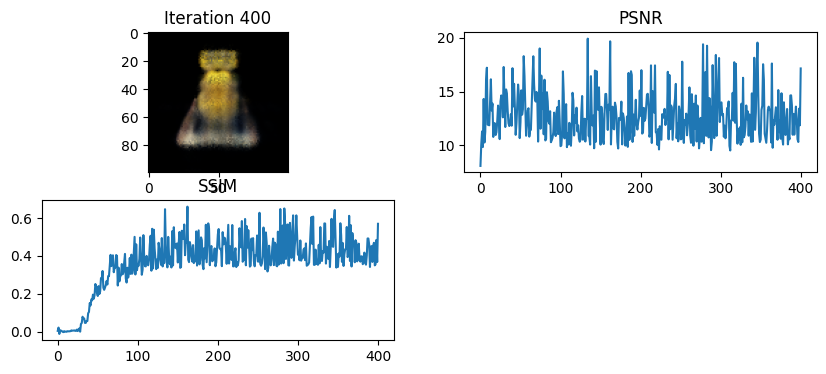

Loss: 0.05594276636838913
Loss: 0.052887238562107086
Loss: 0.02419845014810562
Loss: 0.03581894934177399
Loss: 0.0607253760099411
Loss: 0.08036496490240097
Loss: 0.05400534346699715
Loss: 0.0804976373910904
Loss: 0.0200139582157135
Loss: 0.08756901323795319
Loss: 0.09129586815834045
Loss: 0.07593100517988205
Loss: 0.055039044469594955
Loss: 0.035092685371637344
Loss: 0.05685335770249367
Loss: 0.06043733283877373
Loss: 0.05884125083684921
Loss: 0.08578351885080338
Loss: 0.08640266954898834
Loss: 0.01387543324381113
Loss: 0.021919449791312218
Loss: 0.0928959771990776
Loss: 0.05982191115617752
Loss: 0.01795721985399723
Loss: 0.05541723966598511
Loss: 0.06014017388224602
Loss: 0.07974988967180252
Loss: 0.03535647690296173
Loss: 0.032000232487916946
Loss: 0.08006540685892105
Loss: 0.05656403675675392
Loss: 0.08249876648187637
Loss: 0.06484441459178925
Loss: 0.06273957341909409
Loss: 0.09173518419265747
Loss: 0.09191334992647171
Loss: 0.04634467139840126
Loss: 0.10954954475164413
Loss: 0.051

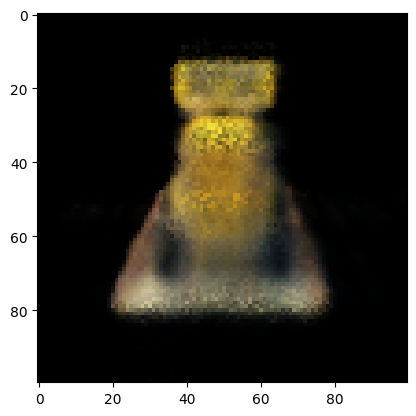

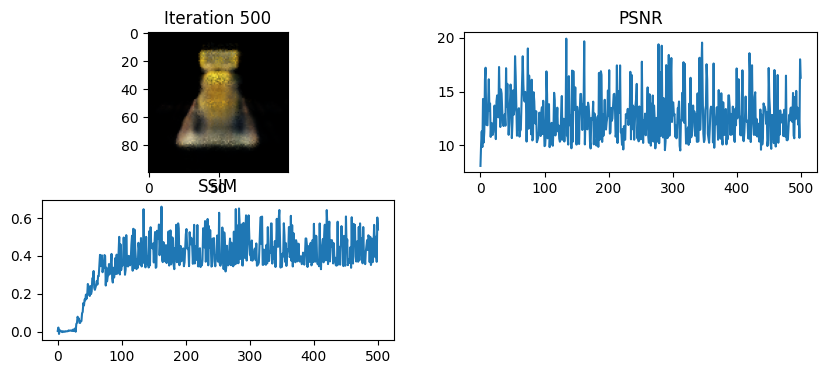

Loss: 0.0669981986284256
Loss: 0.05673777684569359
Loss: 0.04504958912730217
Loss: 0.04509573429822922
Loss: 0.101178839802742
Loss: 0.04966794699430466
Loss: 0.03228935971856117
Loss: 0.03338678553700447
Loss: 0.04112071171402931
Loss: 0.08449447154998779
Loss: 0.04737206920981407
Loss: 0.10508202016353607
Loss: 0.06617201864719391
Loss: 0.020851656794548035
Loss: 0.09336430579423904
Loss: 0.05822043493390083
Loss: 0.06151629239320755
Loss: 0.06598971039056778
Loss: 0.0558062419295311
Loss: 0.09359181672334671
Loss: 0.05007109418511391
Loss: 0.05552520975470543
Loss: 0.05309590324759483
Loss: 0.10065443068742752
Loss: 0.05255034193396568
Loss: 0.04432178661227226
Loss: 0.054027147591114044
Loss: 0.0554577000439167
Loss: 0.016227252781391144
Loss: 0.05057112127542496
Loss: 0.08021372556686401
Loss: 0.09996383637189865
Loss: 0.02348829060792923
Loss: 0.05141729488968849
Loss: 0.01492685079574585
Loss: 0.08244616538286209
Loss: 0.053849369287490845
Loss: 0.04894423484802246
Loss: 0.05635

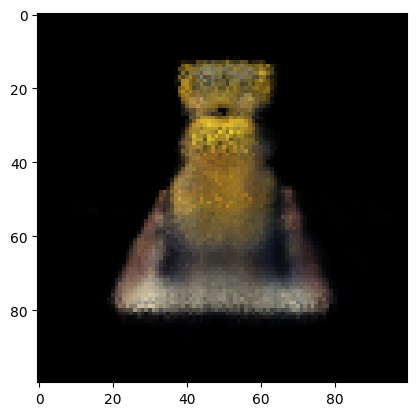

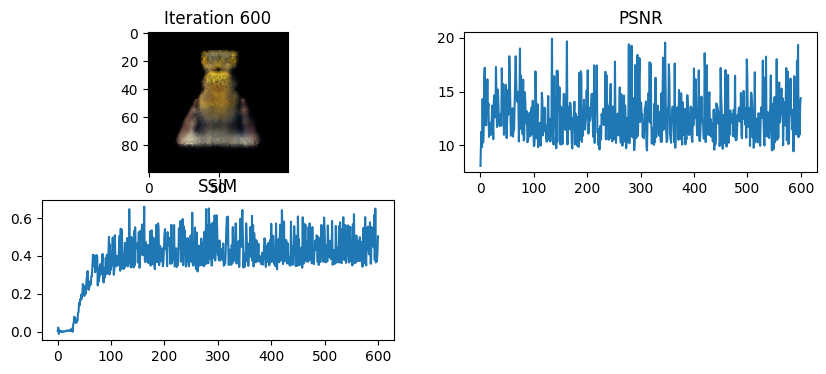

Loss: 0.04581645503640175
Loss: 0.05645392835140228
Loss: 0.07048168033361435
Loss: 0.046448830515146255
Loss: 0.06988447904586792
Loss: 0.052651550620794296
Loss: 0.04872359335422516
Loss: 0.05853690579533577
Loss: 0.019575968384742737
Loss: 0.10010743886232376
Loss: 0.0849820151925087
Loss: 0.07334011793136597
Loss: 0.03360505774617195
Loss: 0.046066928654909134
Loss: 0.057997703552246094
Loss: 0.019125383347272873
Loss: 0.06286278367042542
Loss: 0.10364590585231781
Loss: 0.057697661221027374
Loss: 0.07055284827947617
Loss: 0.10192983597517014
Loss: 0.08185312151908875
Loss: 0.09360747039318085
Loss: 0.09844797849655151
Loss: 0.04586707055568695
Loss: 0.01572861522436142
Loss: 0.09901116788387299
Loss: 0.07803195714950562
Loss: 0.09652627259492874
Loss: 0.09370765835046768
Loss: 0.03646199032664299
Loss: 0.04475784674286842
Loss: 0.08703232556581497
Loss: 0.05220702663064003
Loss: 0.09856083244085312
Loss: 0.03230195865035057
Loss: 0.10201076418161392
Loss: 0.07903291285037994
Loss: 

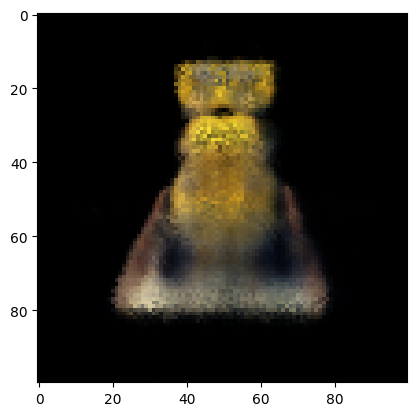

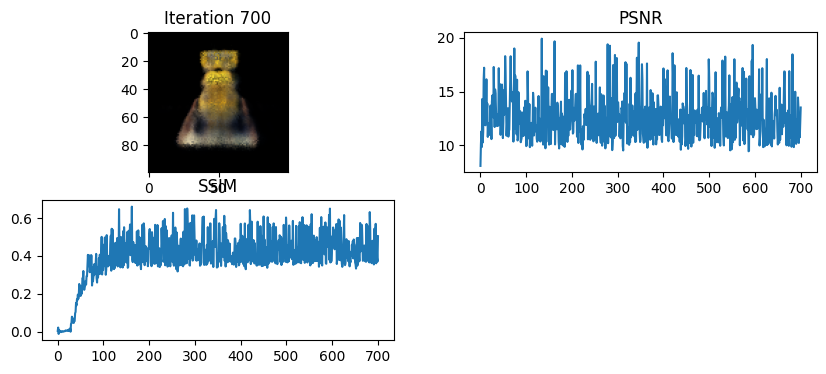

Loss: 0.08663451671600342
Loss: 0.09944138675928116
Loss: 0.05193392559885979
Loss: 0.10207117348909378
Loss: 0.09436697512865067
Loss: 0.033589787781238556
Loss: 0.019706793129444122
Loss: 0.07988909631967545
Loss: 0.06060093268752098
Loss: 0.07268667221069336
Loss: 0.06512521207332611
Loss: 0.10075554996728897
Loss: 0.051349278539419174
Loss: 0.033064112067222595
Loss: 0.02748127467930317
Loss: 0.04764564707875252
Loss: 0.1104532852768898
Loss: 0.07082749158143997
Loss: 0.0211714468896389
Loss: 0.015777552500367165
Loss: 0.0553085058927536
Loss: 0.05239560827612877
Loss: 0.09731315821409225
Loss: 0.05652729421854019
Loss: 0.07952720671892166
Loss: 0.05737476795911789
Loss: 0.09912393987178802
Loss: 0.08272979408502579
Loss: 0.0454280711710453
Loss: 0.06589174270629883
Loss: 0.028086399659514427
Loss: 0.05070098862051964
Loss: 0.055587783455848694
Loss: 0.07657550275325775
Loss: 0.05457866191864014
Loss: 0.0360846146941185
Loss: 0.05628634989261627
Loss: 0.060478243976831436
Loss: 0.0

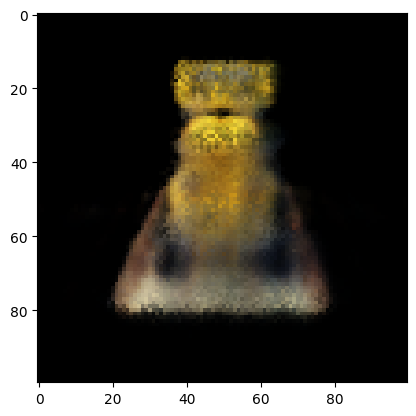

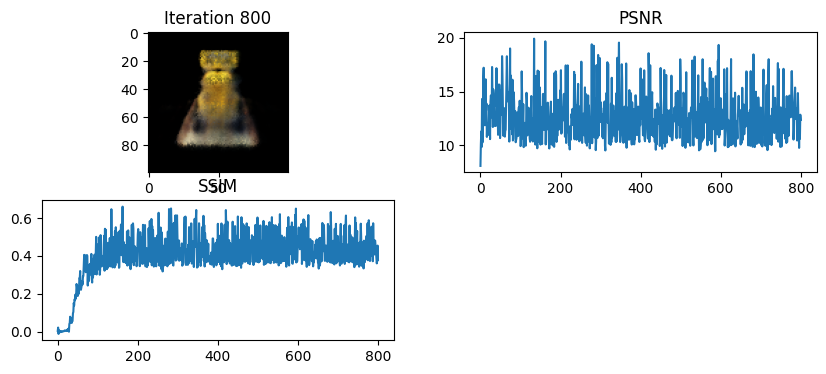

Loss: 0.06052900478243828
Loss: 0.08075621724128723
Loss: 0.026551470160484314
Loss: 0.07152432203292847
Loss: 0.09331785142421722
Loss: 0.09767867624759674
Loss: 0.08336465060710907
Loss: 0.07228244096040726
Loss: 0.08885513246059418
Loss: 0.04151889681816101
Loss: 0.06273920834064484
Loss: 0.09542236477136612
Loss: 0.09692457318305969
Loss: 0.05762149766087532
Loss: 0.10241091996431351
Loss: 0.07895294576883316
Loss: 0.04575514793395996
Loss: 0.06877008825540543
Loss: 0.05237976089119911
Loss: 0.052624333649873734
Loss: 0.05855908617377281
Loss: 0.08333403617143631
Loss: 0.03469400480389595
Loss: 0.048872001469135284
Loss: 0.09679239988327026
Loss: 0.0849679559469223
Loss: 0.05626562610268593
Loss: 0.04645940288901329
Loss: 0.09509197622537613
Loss: 0.08488137274980545
Loss: 0.08590695261955261
Loss: 0.05317582190036774
Loss: 0.08845710754394531
Loss: 0.057179175317287445
Loss: 0.06692097336053848
Loss: 0.022358126938343048
Loss: 0.051194898784160614
Loss: 0.02046540565788746
Loss: 0

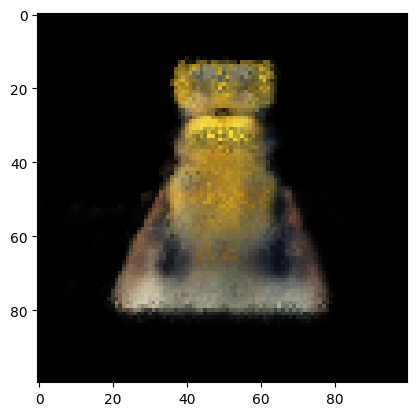

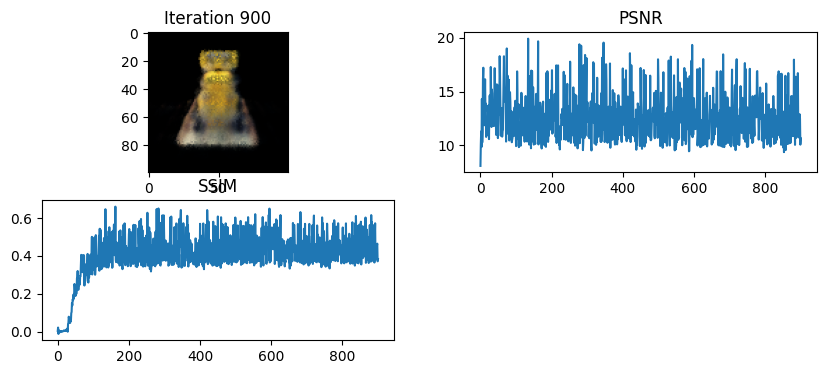

Loss: 0.0677640438079834
Loss: 0.08772062510251999
Loss: 0.07775232940912247
Loss: 0.09593989700078964
Loss: 0.08129324018955231
Loss: 0.05655595287680626
Loss: 0.09074806421995163
Loss: 0.08818423002958298
Loss: 0.05002583563327789
Loss: 0.04912147670984268
Loss: 0.058271557092666626
Loss: 0.11323218047618866
Loss: 0.0970035046339035
Loss: 0.09523025900125504
Loss: 0.08579713851213455
Loss: 0.0887719914317131
Loss: 0.042420901358127594
Loss: 0.11343856155872345
Loss: 0.03406968712806702
Loss: 0.021943392232060432
Loss: 0.05438762158155441
Loss: 0.04752121493220329
Loss: 0.10183223336935043
Loss: 0.06648001074790955
Loss: 0.06761816889047623
Loss: 0.10156065225601196
Loss: 0.09985669702291489
Loss: 0.04774307832121849
Loss: 0.059524353593587875
Loss: 0.07240039110183716
Loss: 0.05206489562988281
Loss: 0.09860416501760483
Loss: 0.02112417109310627
Loss: 0.0354042686522007
Loss: 0.10381562262773514
Loss: 0.08810601383447647
Loss: 0.09529270231723785
Loss: 0.07317513972520828
Loss: 0.0718

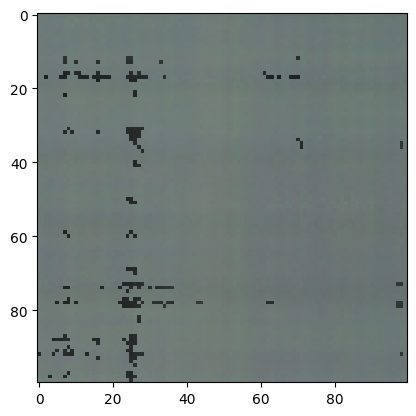

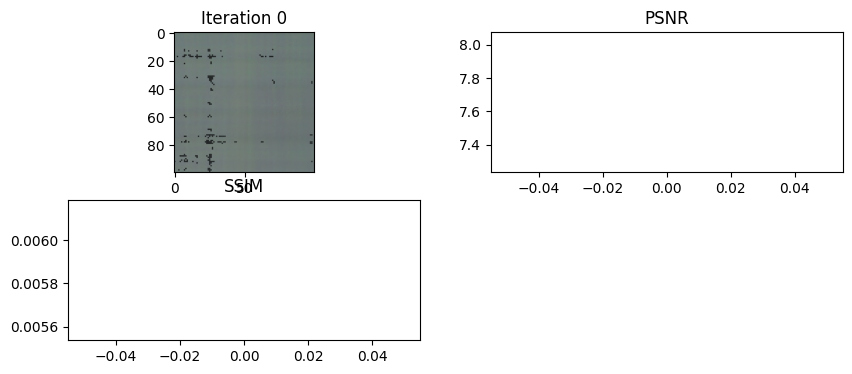

Loss: 0.10238352417945862
Loss: 0.0258698258548975
Loss: 0.08855074644088745
Loss: 0.033740632236003876
Loss: 0.04966990649700165
Loss: 0.06691198796033859
Loss: 0.031561873853206635
Loss: 0.018478600308299065
Loss: 0.04850498586893082
Loss: 0.09206269681453705
Loss: 0.08581625670194626
Loss: 0.01735660992562771
Loss: 0.08433377742767334
Loss: 0.03615722805261612
Loss: 0.11489742994308472
Loss: 0.05347725376486778
Loss: 0.06648046523332596
Loss: 0.02529671974480152
Loss: 0.04333196207880974
Loss: 0.06727156788110733
Loss: 0.06473097205162048
Loss: 0.021484624594449997
Loss: 0.03535028547048569
Loss: 0.07000550627708435
Loss: 0.04506254568696022
Loss: 0.01359577663242817
Loss: 0.06881551444530487
Loss: 0.053465042263269424
Loss: 0.013882036320865154
Loss: 0.0416988879442215
Loss: 0.042295169085264206
Loss: 0.05501440167427063
Loss: 0.059737637639045715
Loss: 0.06611445546150208
Loss: 0.06308642774820328
Loss: 0.04450405761599541
Loss: 0.053538303822278976
Loss: 0.05347789451479912
Loss:

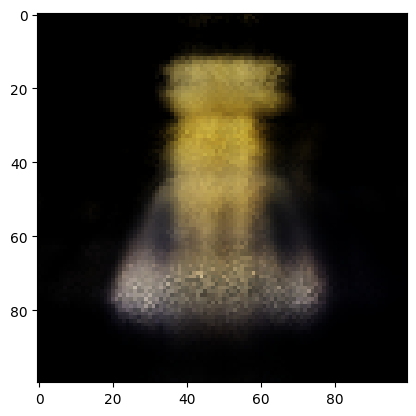

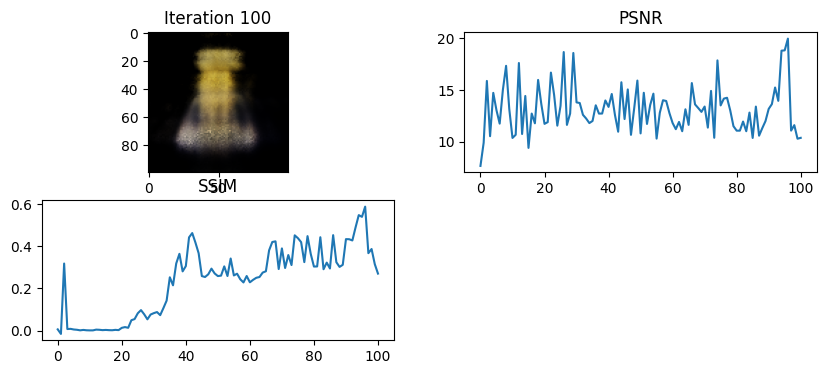

Loss: 0.0575321726500988
Loss: 0.08875486999750137
Loss: 0.027706317603588104
Loss: 0.03351675346493721
Loss: 0.06314501911401749
Loss: 0.06250012665987015
Loss: 0.053196221590042114
Loss: 0.11855867505073547
Loss: 0.10609637200832367
Loss: 0.08663507550954819
Loss: 0.06812814623117447
Loss: 0.04647427052259445
Loss: 0.09348751604557037
Loss: 0.08890483528375626
Loss: 0.04098839685320854
Loss: 0.04642200842499733
Loss: 0.06200610473752022
Loss: 0.09227913618087769
Loss: 0.06052742153406143
Loss: 0.10561081022024155
Loss: 0.012505661696195602
Loss: 0.029846442863345146
Loss: 0.06314855068922043
Loss: 0.09795672446489334
Loss: 0.07651548087596893
Loss: 0.04793189465999603
Loss: 0.045793406665325165
Loss: 0.08906666189432144
Loss: 0.05030502378940582
Loss: 0.03733401745557785
Loss: 0.09692372381687164
Loss: 0.07941777259111404
Loss: 0.047021035104990005
Loss: 0.06468041986227036
Loss: 0.07677099108695984
Loss: 0.06993544101715088
Loss: 0.07652131468057632
Loss: 0.10191930830478668
Loss: 0

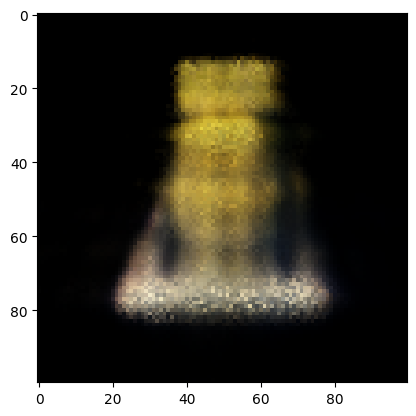

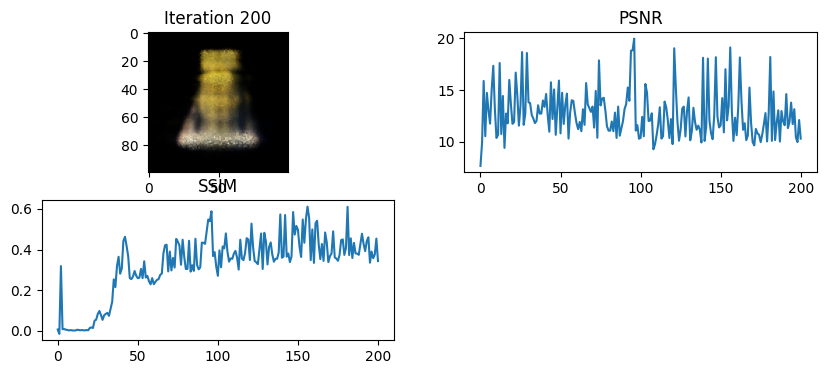

Loss: 0.09025414288043976
Loss: 0.08965153992176056
Loss: 0.05351794883608818
Loss: 0.08330409228801727
Loss: 0.11168945580720901
Loss: 0.06006329879164696
Loss: 0.062435876578092575
Loss: 0.1068316325545311
Loss: 0.10464873164892197
Loss: 0.038761671632528305
Loss: 0.10240829735994339
Loss: 0.07070509344339371
Loss: 0.05550471320748329
Loss: 0.04938838258385658
Loss: 0.07395646721124649
Loss: 0.040864698588848114
Loss: 0.07332132756710052
Loss: 0.04407605156302452
Loss: 0.04363524913787842
Loss: 0.09192647784948349
Loss: 0.10151838511228561
Loss: 0.09022565186023712
Loss: 0.06450176239013672
Loss: 0.07349313795566559
Loss: 0.08598042279481888
Loss: 0.0849045142531395
Loss: 0.0672103613615036
Loss: 0.05379080772399902
Loss: 0.10465268045663834
Loss: 0.01918313466012478
Loss: 0.05449588596820831
Loss: 0.08164694905281067
Loss: 0.06254518777132034
Loss: 0.04996109753847122
Loss: 0.02016652747988701
Loss: 0.050702039152383804
Loss: 0.01684439368546009
Loss: 0.1004696637392044
Loss: 0.0854

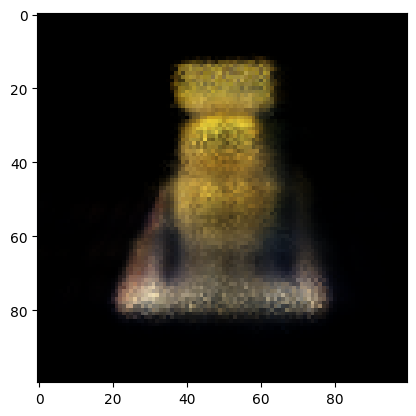

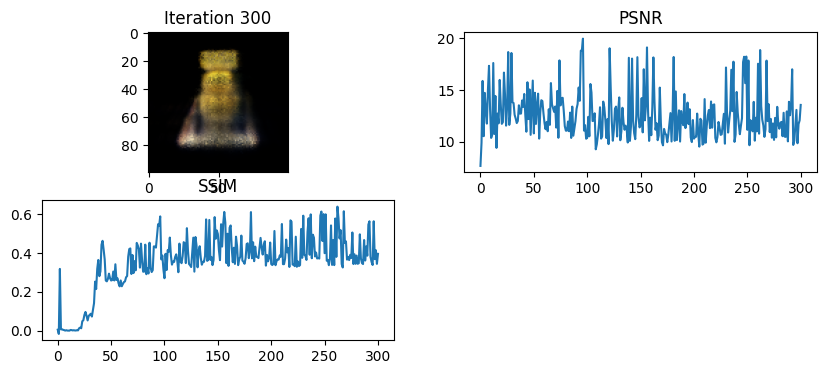

Loss: 0.062132515013217926
Loss: 0.0511111319065094
Loss: 0.05594400316476822
Loss: 0.0997621938586235
Loss: 0.08983297646045685
Loss: 0.06069391593337059
Loss: 0.079445481300354
Loss: 0.018360313028097153
Loss: 0.04346984997391701
Loss: 0.07997596263885498
Loss: 0.035482123494148254
Loss: 0.07081766426563263
Loss: 0.09210903197526932
Loss: 0.09986516088247299
Loss: 0.01990427076816559
Loss: 0.11049669235944748
Loss: 0.08680114895105362
Loss: 0.05206373706459999
Loss: 0.03134414181113243
Loss: 0.04992806166410446
Loss: 0.0615660734474659
Loss: 0.03386826068162918
Loss: 0.05848005414009094
Loss: 0.10548834502696991
Loss: 0.061169832944869995
Loss: 0.032590351998806
Loss: 0.07125086337327957
Loss: 0.04905656352639198
Loss: 0.04304491728544235
Loss: 0.055615056306123734
Loss: 0.031739503145217896
Loss: 0.03156765177845955
Loss: 0.04864756017923355
Loss: 0.09511005878448486
Loss: 0.01841071806848049
Loss: 0.06642360985279083
Loss: 0.0695972591638565
Loss: 0.03222719952464104
Loss: 0.015610

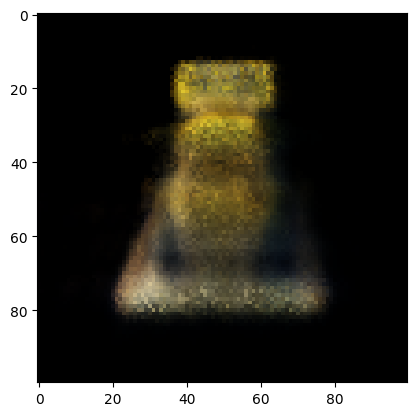

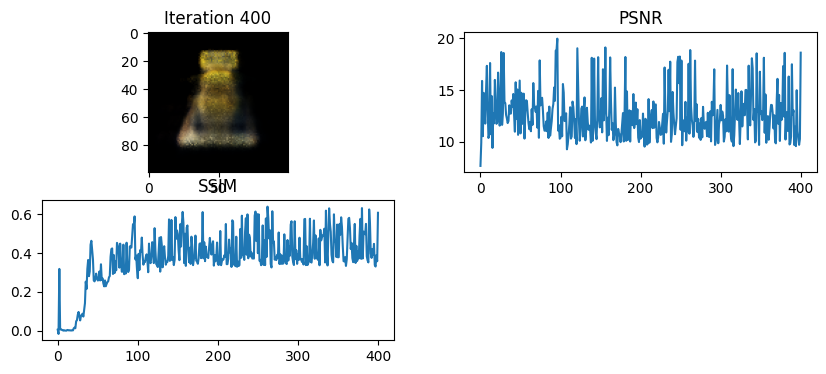

Loss: 0.10928000509738922
Loss: 0.07047863304615021
Loss: 0.10114151239395142
Loss: 0.045446403324604034
Loss: 0.11190248280763626
Loss: 0.08311164379119873
Loss: 0.05420313775539398
Loss: 0.05448431149125099
Loss: 0.015343043021857738
Loss: 0.08601684868335724
Loss: 0.044934071600437164
Loss: 0.043780792504549026
Loss: 0.05240675061941147
Loss: 0.03121926821768284
Loss: 0.05003158748149872
Loss: 0.02964305505156517
Loss: 0.04886671528220177
Loss: 0.06996983289718628
Loss: 0.046808239072561264
Loss: 0.07383503764867783
Loss: 0.05403563752770424
Loss: 0.05074666067957878
Loss: 0.10356596112251282
Loss: 0.06484150886535645
Loss: 0.015228831209242344
Loss: 0.05257292091846466
Loss: 0.09148935228586197
Loss: 0.05712493881583214
Loss: 0.08982742577791214
Loss: 0.04684111475944519
Loss: 0.08987239003181458
Loss: 0.048875097185373306
Loss: 0.07080177962779999
Loss: 0.020887764170765877
Loss: 0.06102338060736656
Loss: 0.04999030381441116
Loss: 0.06078985333442688
Loss: 0.018055468797683716
Los

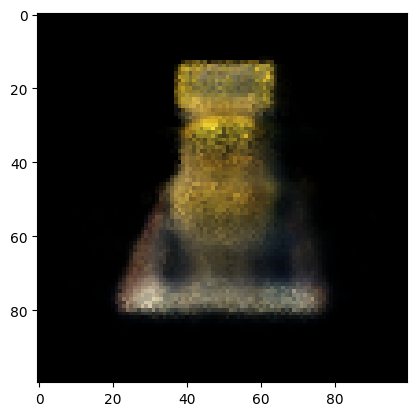

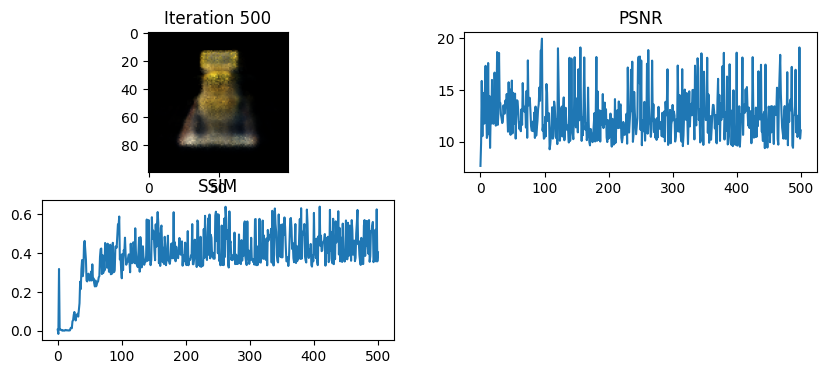

Loss: 0.09264664351940155
Loss: 0.01831328123807907
Loss: 0.05002186819911003
Loss: 0.056003935635089874
Loss: 0.0817459225654602
Loss: 0.02203935571014881
Loss: 0.04404756426811218
Loss: 0.036864589899778366
Loss: 0.10819455236196518
Loss: 0.10189466178417206
Loss: 0.09284612536430359
Loss: 0.05801304802298546
Loss: 0.08079348504543304
Loss: 0.06324858218431473
Loss: 0.050389889627695084
Loss: 0.08725973963737488
Loss: 0.01689739339053631
Loss: 0.06225129961967468
Loss: 0.018727032467722893
Loss: 0.061721041798591614
Loss: 0.01742410846054554
Loss: 0.10279931873083115
Loss: 0.08060260862112045
Loss: 0.014199556782841682
Loss: 0.05196162685751915
Loss: 0.09216732531785965
Loss: 0.061596985906362534
Loss: 0.0662243515253067
Loss: 0.08273066580295563
Loss: 0.01963159814476967
Loss: 0.0540914423763752
Loss: 0.05082329362630844
Loss: 0.051137905567884445
Loss: 0.06656768172979355
Loss: 0.06642784923315048
Loss: 0.03496327996253967
Loss: 0.10235925763845444
Loss: 0.04805658757686615
Loss: 0

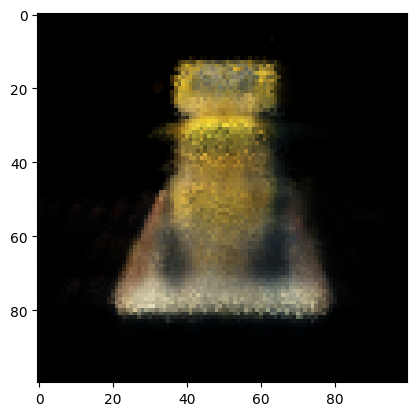

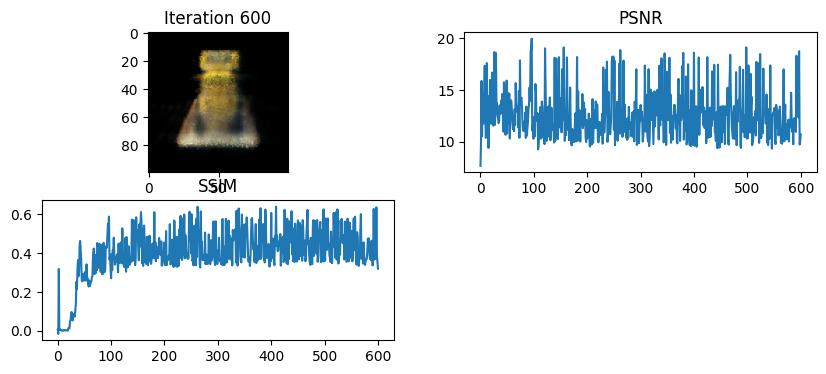

Loss: 0.03851618617773056
Loss: 0.040572404861450195
Loss: 0.09965900331735611
Loss: 0.07883791625499725
Loss: 0.04436824098229408
Loss: 0.11115808039903641
Loss: 0.07733470946550369
Loss: 0.087567038834095
Loss: 0.10322420299053192
Loss: 0.08377492427825928
Loss: 0.03898074850440025
Loss: 0.09566456824541092
Loss: 0.02025729976594448
Loss: 0.05941588431596756
Loss: 0.04765334352850914
Loss: 0.05527759715914726
Loss: 0.057267311960458755
Loss: 0.09499558806419373
Loss: 0.0799943208694458
Loss: 0.05959111079573631
Loss: 0.08658522367477417
Loss: 0.018117476254701614
Loss: 0.10179339349269867
Loss: 0.02000526338815689
Loss: 0.07016590237617493
Loss: 0.07918621599674225
Loss: 0.1023564338684082
Loss: 0.10890679806470871
Loss: 0.09887182712554932
Loss: 0.09317115694284439
Loss: 0.09215450286865234
Loss: 0.017110629007220268
Loss: 0.0727248564362526
Loss: 0.05330001935362816
Loss: 0.10545021295547485
Loss: 0.05270961672067642
Loss: 0.04662690311670303
Loss: 0.09980669617652893
Loss: 0.05727

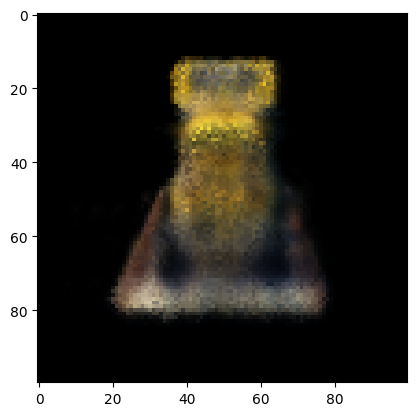

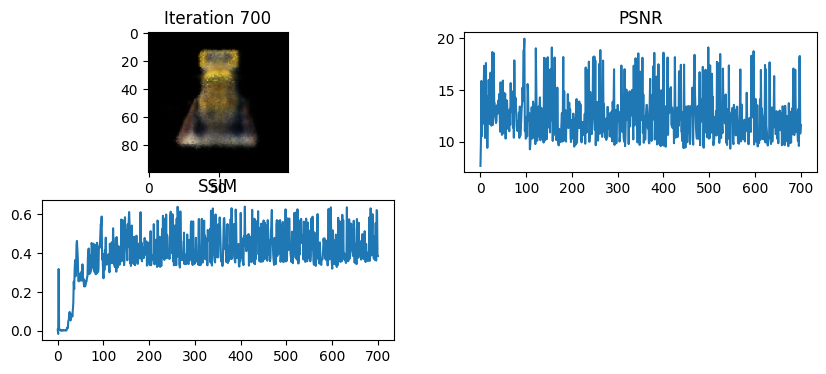

Loss: 0.014921121299266815
Loss: 0.10727205872535706
Loss: 0.030323242768645287
Loss: 0.07714831084012985
Loss: 0.10439202189445496
Loss: 0.10364724695682526
Loss: 0.06105421483516693
Loss: 0.10326157510280609
Loss: 0.0733635276556015
Loss: 0.05228978022933006
Loss: 0.054661158472299576
Loss: 0.01609211042523384
Loss: 0.06121046841144562
Loss: 0.08445069193840027
Loss: 0.016228629276156425
Loss: 0.11584006994962692
Loss: 0.09917634725570679
Loss: 0.06360486894845963
Loss: 0.0781884714961052
Loss: 0.06168973073363304
Loss: 0.022068629041314125
Loss: 0.020245246589183807
Loss: 0.08728040009737015
Loss: 0.10072789341211319
Loss: 0.09729622304439545
Loss: 0.09630151093006134
Loss: 0.050551604479551315
Loss: 0.0987151637673378
Loss: 0.01592819206416607
Loss: 0.040648918598890305
Loss: 0.045034002512693405
Loss: 0.1089419424533844
Loss: 0.03532512113451958
Loss: 0.07549173384904861
Loss: 0.09398432075977325
Loss: 0.08328839391469955
Loss: 0.02208581753075123
Loss: 0.044481061398983
Loss: 0.0

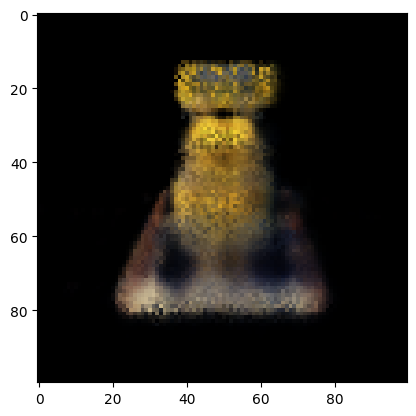

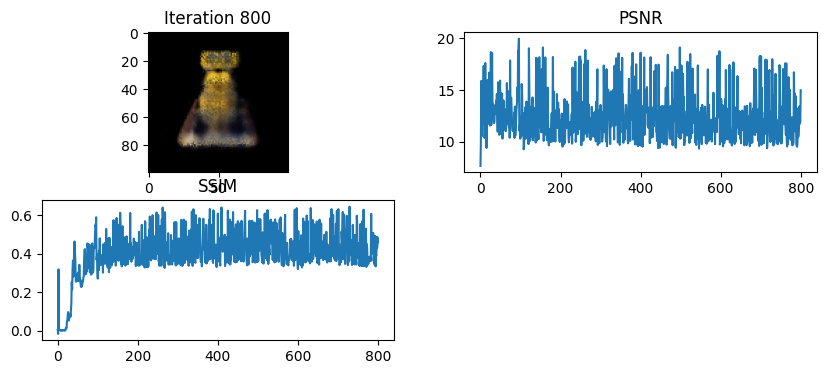

Loss: 0.029829371720552444
Loss: 0.10284242033958435
Loss: 0.09908953309059143
Loss: 0.10995114594697952
Loss: 0.07161814719438553
Loss: 0.06016472727060318
Loss: 0.09083981066942215
Loss: 0.0424233004450798
Loss: 0.07367958873510361
Loss: 0.051397085189819336
Loss: 0.01809568516910076
Loss: 0.05613339692354202
Loss: 0.03046363592147827
Loss: 0.05853947997093201
Loss: 0.06229836493730545
Loss: 0.05353434756398201
Loss: 0.07031212747097015
Loss: 0.0520491860806942
Loss: 0.037296656519174576
Loss: 0.01722157746553421
Loss: 0.03356100618839264
Loss: 0.0793866291642189
Loss: 0.04921119287610054
Loss: 0.04349678382277489
Loss: 0.08554210513830185
Loss: 0.013617468066513538
Loss: 0.047230400145053864
Loss: 0.09099582582712173
Loss: 0.030193842947483063
Loss: 0.09140315651893616
Loss: 0.05589975416660309
Loss: 0.05716433748602867
Loss: 0.06824298202991486
Loss: 0.07066436111927032
Loss: 0.06480880826711655
Loss: 0.10015614330768585
Loss: 0.10120265930891037
Loss: 0.08708161860704422
Loss: 0.1

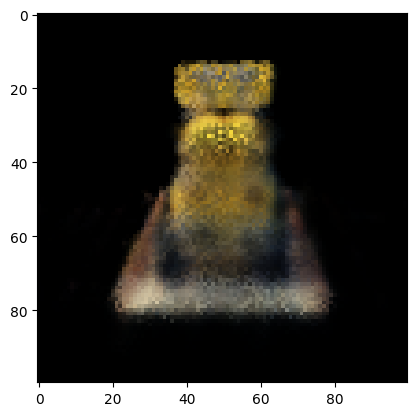

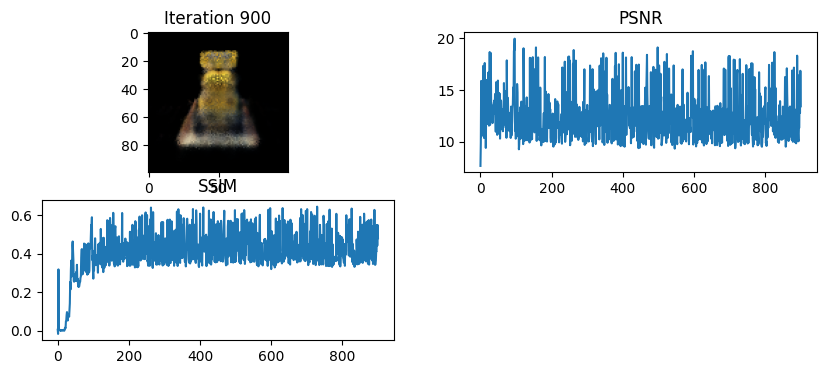

Loss: 0.05133527144789696
Loss: 0.012715687975287437
Loss: 0.10647130757570267
Loss: 0.050371259450912476
Loss: 0.06330658495426178
Loss: 0.04803090915083885
Loss: 0.04350528120994568
Loss: 0.01848302222788334
Loss: 0.053042419254779816
Loss: 0.09337861090898514
Loss: 0.05301860719919205
Loss: 0.09918321669101715
Loss: 0.014710551127791405
Loss: 0.08346160501241684
Loss: 0.05048728361725807
Loss: 0.10935699194669724
Loss: 0.013038627803325653
Loss: 0.05163632333278656
Loss: 0.01743573695421219
Loss: 0.07944504916667938
Loss: 0.05560407042503357
Loss: 0.10334804654121399
Loss: 0.052860818803310394
Loss: 0.02345111407339573
Loss: 0.019924618303775787
Loss: 0.07144153863191605
Loss: 0.0632360428571701
Loss: 0.10061442852020264
Loss: 0.10459344834089279
Loss: 0.095223568379879
Loss: 0.07895611226558685
Loss: 0.09795672446489334
Loss: 0.047222599387168884
Loss: 0.06662296503782272
Loss: 0.05368844419717789
Loss: 0.022717703133821487
Loss: 0.0922924056649208
Loss: 0.08701438456773758
Loss: 0

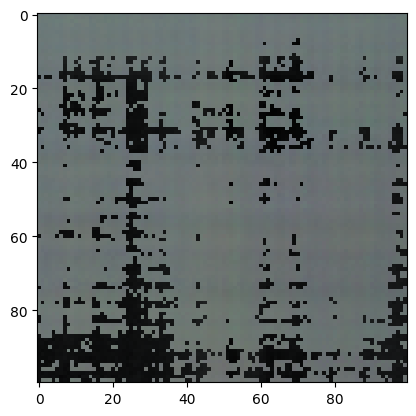

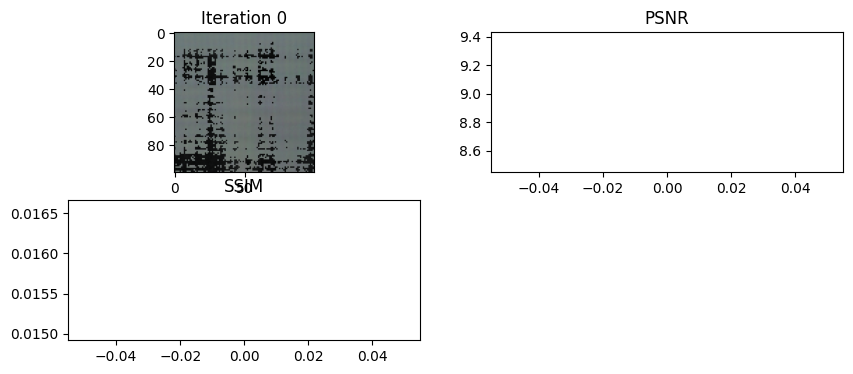

Loss: 0.1503894180059433
Loss: 0.11549863964319229
Loss: 0.07896275818347931
Loss: 0.07106712460517883
Loss: 0.07517124712467194
Loss: 0.061328548938035965
Loss: 0.12960711121559143
Loss: 0.13255968689918518
Loss: 0.12068398296833038
Loss: 0.08501908928155899
Loss: 0.08403080701828003
Loss: 0.024971021339297295
Loss: 0.1082904040813446
Loss: 0.03293506056070328
Loss: 0.039638176560401917
Loss: 0.026529530063271523
Loss: 0.09388990700244904
Loss: 0.10172425210475922
Loss: 0.11344557255506516
Loss: 0.026532022282481194
Loss: 0.09845950454473495
Loss: 0.025430601090192795
Loss: 0.06411835551261902
Loss: 0.12156733125448227
Loss: 0.04601798579096794
Loss: 0.09310010075569153
Loss: 0.04475913569331169
Loss: 0.01760057359933853
Loss: 0.08027545362710953
Loss: 0.04787411168217659
Loss: 0.06872901320457458
Loss: 0.07721790671348572
Loss: 0.039118874818086624
Loss: 0.10098149627447128
Loss: 0.06229992210865021
Loss: 0.06644824892282486
Loss: 0.03856799751520157
Loss: 0.045378677546978
Loss: 0.0

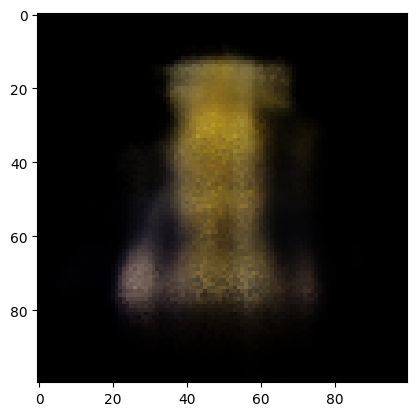

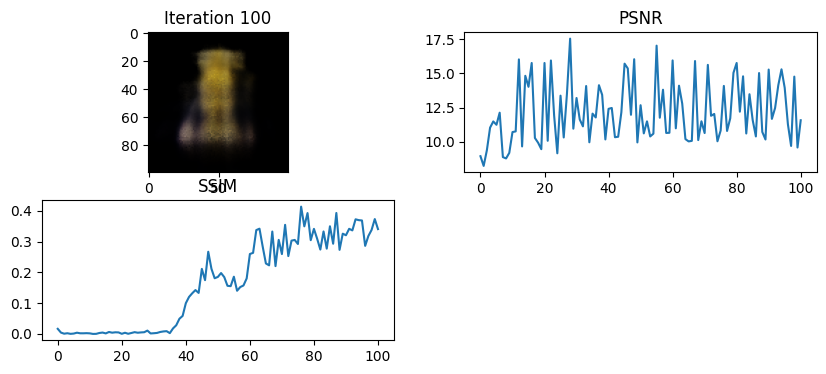

Loss: 0.08771287649869919
Loss: 0.035359032452106476
Loss: 0.049875639379024506
Loss: 0.09414035081863403
Loss: 0.09128262847661972
Loss: 0.08033540844917297
Loss: 0.03463106229901314
Loss: 0.08016447722911835
Loss: 0.03978423774242401
Loss: 0.09377884864807129
Loss: 0.0866435170173645
Loss: 0.03478497639298439
Loss: 0.0948258638381958
Loss: 0.047424089163541794
Loss: 0.0813789889216423
Loss: 0.08972739428281784
Loss: 0.09075091034173965
Loss: 0.058754559606313705
Loss: 0.06546054780483246
Loss: 0.06661635637283325
Loss: 0.10936678200960159
Loss: 0.07971539348363876
Loss: 0.08561970293521881
Loss: 0.06093244254589081
Loss: 0.09023068845272064
Loss: 0.04176444187760353
Loss: 0.08983318507671356
Loss: 0.032951969653367996
Loss: 0.11017227917909622
Loss: 0.05913848429918289
Loss: 0.08297594636678696
Loss: 0.058845773339271545
Loss: 0.09486261755228043
Loss: 0.03230820223689079
Loss: 0.10709817707538605
Loss: 0.060128215700387955
Loss: 0.04015033319592476
Loss: 0.0669010579586029
Loss: 0.1

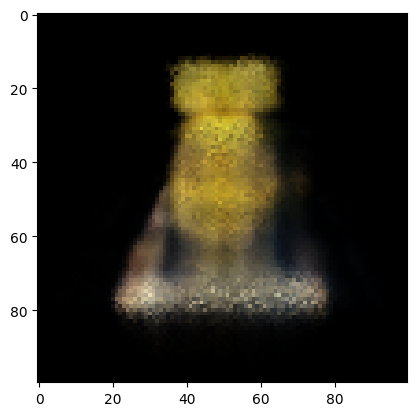

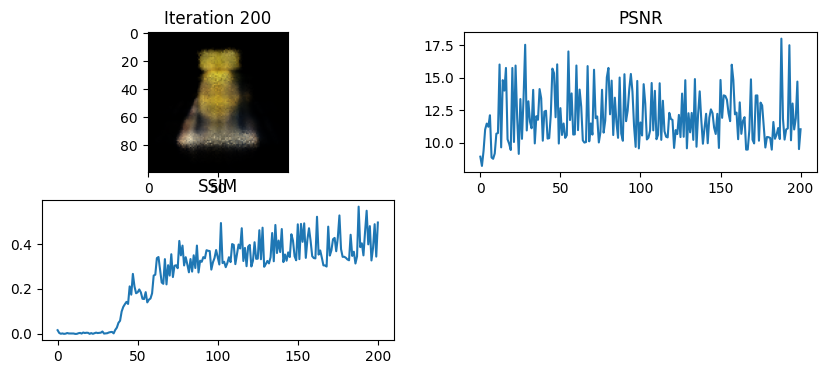

Loss: 0.048399727791547775
Loss: 0.07119999080896378
Loss: 0.09243945777416229
Loss: 0.08174999803304672
Loss: 0.0275324247777462
Loss: 0.09527639299631119
Loss: 0.07902621477842331
Loss: 0.08860888332128525
Loss: 0.03315145522356033
Loss: 0.07820741832256317
Loss: 0.09505145996809006
Loss: 0.08078666031360626
Loss: 0.03199455514550209
Loss: 0.060892075300216675
Loss: 0.07799698412418365
Loss: 0.09083002060651779
Loss: 0.08208878338336945
Loss: 0.045669689774513245
Loss: 0.062225326895713806
Loss: 0.06707640737295151
Loss: 0.11253641545772552
Loss: 0.04393372684717178
Loss: 0.062387969344854355
Loss: 0.05984756350517273
Loss: 0.08605743944644928
Loss: 0.05021914094686508
Loss: 0.08307883143424988
Loss: 0.04680787771940231
Loss: 0.0587637759745121
Loss: 0.04742911085486412
Loss: 0.08069957792758942
Loss: 0.033511143177747726
Loss: 0.09662041813135147
Loss: 0.07933185994625092
Loss: 0.0652271956205368
Loss: 0.05959918349981308
Loss: 0.07455820590257645
Loss: 0.09074080735445023
Loss: 0.0

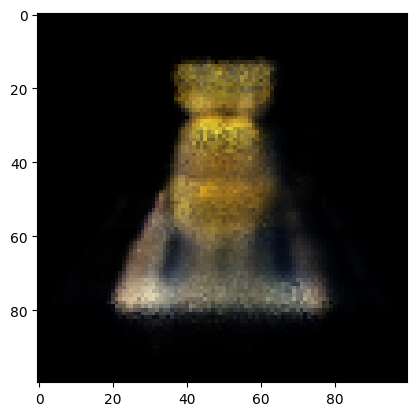

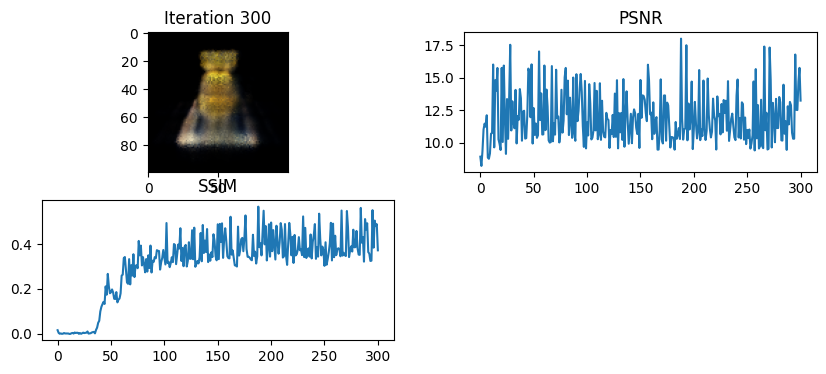

Loss: 0.0963721051812172
Loss: 0.11045951396226883
Loss: 0.032320261001586914
Loss: 0.052077531814575195
Loss: 0.05033193528652191
Loss: 0.09378662705421448
Loss: 0.08569885045289993
Loss: 0.0466570109128952
Loss: 0.055545929819345474
Loss: 0.016996590420603752
Loss: 0.034200623631477356
Loss: 0.09422504901885986
Loss: 0.04424671083688736
Loss: 0.05614788457751274
Loss: 0.11324559152126312
Loss: 0.0336323156952858
Loss: 0.0657975822687149
Loss: 0.034925512969493866
Loss: 0.042691946029663086
Loss: 0.02260586805641651
Loss: 0.07229219377040863
Loss: 0.03462216258049011
Loss: 0.03438304364681244
Loss: 0.044280044734478
Loss: 0.05979729816317558
Loss: 0.0554235465824604
Loss: 0.08097083121538162
Loss: 0.035106100142002106
Loss: 0.07949469238519669
Loss: 0.07658227533102036
Loss: 0.05201371759176254
Loss: 0.04570288583636284
Loss: 0.09735438972711563
Loss: 0.08004563301801682
Loss: 0.0438067652285099
Loss: 0.07385668903589249
Loss: 0.10754391551017761
Loss: 0.06270982325077057
Loss: 0.0300

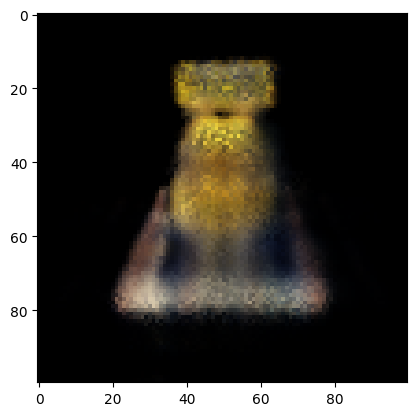

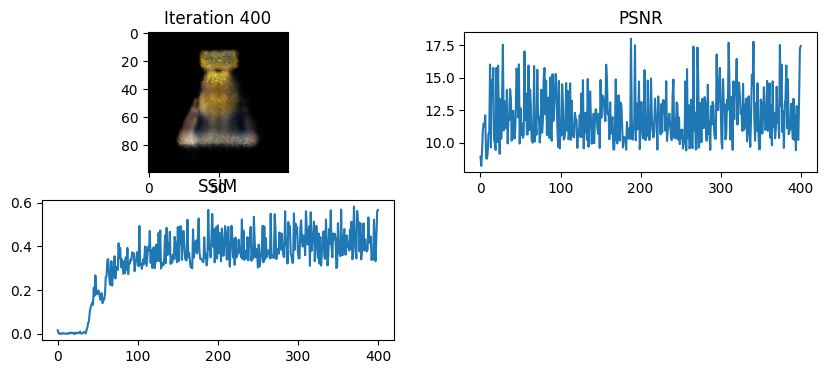

Loss: 0.07770919799804688
Loss: 0.0851132795214653
Loss: 0.0961618572473526
Loss: 0.03537186235189438
Loss: 0.06864257901906967
Loss: 0.11259928345680237
Loss: 0.04634970426559448
Loss: 0.08372268825769424
Loss: 0.07947620749473572
Loss: 0.08186342567205429
Loss: 0.09747522324323654
Loss: 0.07849215716123581
Loss: 0.09963063895702362
Loss: 0.08708199113607407
Loss: 0.06330923736095428
Loss: 0.11476465314626694
Loss: 0.04601133614778519
Loss: 0.058680564165115356
Loss: 0.08454959094524384
Loss: 0.08192577213048935
Loss: 0.09398847818374634
Loss: 0.05557604134082794
Loss: 0.09928656369447708
Loss: 0.08115851879119873
Loss: 0.06232473626732826
Loss: 0.09384088218212128
Loss: 0.052538011223077774
Loss: 0.08171717077493668
Loss: 0.05618610978126526
Loss: 0.08790941536426544
Loss: 0.04625656455755234


KeyboardInterrupt: 

In [19]:
# Load input images, poses, and intrinsics
data = np.load("tiny_nerf_data.npz")

## my code

for n_discards in [11, 21, 31, 41, 51, 61, 71, 81, 91, 101]:
    # Images
    images = data["images"]

    ## my code
    test_indices = np.random.choice(len(images), n_discards, replace=False)
    # adding 0 index image, it's always used for testing
    test_indices = np.append(test_indices[1:], np.array([0]))

    # Camera extrinsics (poses)
    tform_cam2world = data["poses"]
    # tform_cam2world = torch.from_numpy(tform_cam2world).to(device)
    # Focal length (intrinsics)
    focal_length = data["focal"]
    focal_length = torch.from_numpy(focal_length).to(device)

    # Height and width of each image
    height, width = images.shape[1:3]

    # Near and far clipping thresholds for depth values.
    near_thresh = 2.
    far_thresh = 6.

    # Hold one image out (for test).
    # testimg, testpose = images[101], tform_cam2world[101]
    ## my code

    testimg, testpose = images[0], tform_cam2world[0]

    train_images = np.delete(images, test_indices, axis=0)
    train_poses = np.delete(tform_cam2world, test_indices, axis=0)
    tform_cam2world = torch.from_numpy(train_poses).to(device)
    testpose = torch.from_numpy(testpose).to(device)

    testimg = torch.from_numpy(testimg).to(device)

    images = torch.from_numpy(train_images[..., :3]).to(device)

    # Map images to device
    # images = torch.from_numpy(images[:100, ..., :3]).to(device)

    """
    Parameters for TinyNeRF training
    """

    # Number of functions used in the positional encoding (Be sure to update the
    # model if this number changes).
    num_encoding_functions = 6
    # Specify encoding function.
    encode = lambda x: positional_encoding(x, num_encoding_functions=num_encoding_functions)
    # Number of depth samples along each ray.
    depth_samples_per_ray = 32

    # Chunksize (Note: this isn't batchsize in the conventional sense. This only
    # specifies the number of rays to be queried in one go. Backprop still happens
    # only after all rays from the current "bundle" are queried and rendered).
    chunksize = 16384  # Use chunksize of about 4096 to fit in ~1.4 GB of GPU memory.

    # Optimizer parameters
    lr = 5e-3
    num_iters = 1000

    # Misc parameters
    display_every = 100  # Number of iters after which stats are displayed
    record_every = 1

    """
    Model
    """
    model = VeryTinyNerfModel(num_encoding_functions=num_encoding_functions)
    model.to(device)

    """
    Optimizer
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    """
    Train-Eval-Repeat!
    """

    # Seed RNG, for repeatability
    seed = 9458
    torch.manual_seed(seed)
    np.random.seed(seed)

    # Lists to log metrics etc.
    psnrs = []
    ssims = []
    nrmses = []
    iternums = []

    for i in range(num_iters):

        # Randomly pick an image as the target.
        target_img_idx = np.random.randint(images.shape[0])
        target_img = images[target_img_idx].to(device)
        target_tform_cam2world = tform_cam2world[target_img_idx].to(device)

        # Run one iteration of TinyNeRF and get the rendered RGB image.
        rgb_predicted = run_one_iter_of_tinynerf(height, width, focal_length,
                                                target_tform_cam2world, near_thresh,
                                                far_thresh, depth_samples_per_ray,
                                                encode, get_minibatches)

        # Compute mean-squared error between the predicted and target images. Backprop!
        loss = torch.nn.functional.mse_loss(rgb_predicted, target_img)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Display images/plots/stats
        if i % record_every == 0:
            # Render the held-out view
            rgb_predicted = run_one_iter_of_tinynerf(height, width, focal_length,
                                                    testpose, near_thresh,
                                                    far_thresh, depth_samples_per_ray,
                                                    encode, get_minibatches)
            loss = torch.nn.functional.mse_loss(rgb_predicted, target_img)
            print("Loss:", loss.item())
            psnr = -10. * torch.log10(loss)

            psnrs.append(psnr.item())
            iternums.append(i)

            # # SSIM calculation
            # from torch to numpy
            rgb_predicted1 = rgb_predicted.detach().cpu().numpy()
            target_img1 =target_img.cpu().numpy().astype(np.float64)

            # converting to grayscale
            rgb_predicted1 = rgb2gray(rgb_predicted1)
            target_img1 = rgb2gray(target_img1)

            ssim_noise = ssim(target_img1, rgb_predicted1,
                                data_range=rgb_predicted1.max() - rgb_predicted1.min())

            ssims.append(ssim_noise)

            if i % display_every == 0:
                # Save the image locally
                rgb_array = rgb_predicted.detach().cpu().numpy()
                plt.imshow(rgb_array)
                plt.imsave(f'test_metrics/output_imgs/1000iters_{n_discards}_epoch{i}.png', rgb_array)
                
                plt.figure(figsize=(10, 4))
                plt.subplot(221)
                plt.imshow(rgb_predicted.detach().cpu().numpy())
                plt.title(f"Iteration {i}")
                plt.subplot(222)
                plt.plot(iternums, psnrs)
                plt.title("PSNR")
                plt.subplot(223)
                plt.plot(iternums, ssims)
                plt.title("SSIM")
                plt.show()

    with open(f'psnrs_lego_1000iters_{n_discards}_1.json', 'w') as file:
        json.dump(psnrs, file)

    with open(f'ssims_lego_1000iters_{n_discards}_1.json', 'w') as file:
        json.dump(ssims, file)

    print('Done!')

In [40]:
scores = {}
directory = '.'
for file in os.listdir(directory):
    if 'ssims' in file and int(file.split('_')[3]) in [11,21,31,41,51]:
        n_discards = file.split("_")[-2]
        with open(directory+'/'+file) as f:
            d = json.load(f)
        scores[n_discards] = np.mean(d[-10:])

In [42]:
scores = dict(sorted(scores.items(), key=lambda x: int(x[0])))

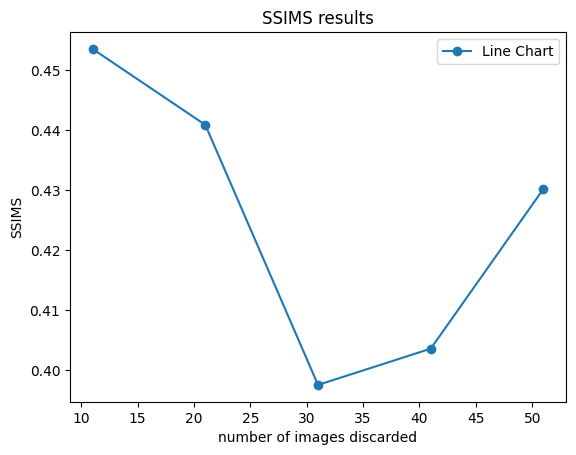

In [43]:
# Extract keys and values from the dictionary
x_values = list(scores.keys())
y_values = list(scores.values())

# Convert keys to integers for proper plotting (assuming x-values are numeric)
x_values = list(map(int, x_values))

# Plot the line chart
plt.plot(x_values, y_values, marker='o', linestyle='-', label='Line Chart')

# Add labels and title
plt.xlabel('number of images discarded')
plt.ylabel('SSIMS')
plt.title('SSIMS results')

# Add a legend
plt.legend()

In [15]:
import json

from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim, normalized_root_mse as nrmse

from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity

import torchvision

import torch.nn.functional as F

def rgb2gray(rgb):
  "used for ssim"
  return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [ ]:
def lpips_input(original_image):
  # Define the patch size (HxW)
  patch_height, patch_width = 32, 32
  # Extract patches from the original image
  patches = F.unfold(original_image.permute(2, 0, 1).unsqueeze(0), (patch_height, patch_width)).squeeze(0)
  # patches is now a tensor of shape [N, 3*H*W], where N is the number of patches

  # Reshape patches to [N, 3, H, W]
  num_patches = patches.shape[0]
  patches = patches.view(num_patches, 3, patch_height, patch_width)

  # Normalize pixel values to [-1, +1]
  patches = (patches / 127.5) - 1.0
  return patches


In [ ]:
# loss_fn = lpips.LPIPS(net='alex')
# rgb_predicted1 = rgb_predicted.detach().cpu()
# target_img1 =target_img.cpu()
lpips = LearnedPerceptualImagePatchSimilarity(net_type='squeeze')
pathes_predict = lpips_input(rgb_predicted)
patches_target = lpips_input(target_img)
lpips(patches_predict, patches_target)

In [ ]:
with open('psnrs_lego_1000iters_0.json', 'r') as file:
    orig_psnrs = json.load(file)
with open('ssims_lego_1000iters_0.json', 'r') as file:
    orig_ssims = json.load(file)
# with open('psnrs_lego_1000iters_1.json', 'r') as file:
#     psnrs = json.load(file)
# with open('ssims_lego_1000iters_1.json', 'r') as file:
#     ssims = json.load(file)
with open('psnrs_lego_1000iters_2.json', 'r') as file:
    psnrs2 = json.load(file)
with open('ssims_lego_1000iters_2.json', 'r') as file:
    ssims2 = json.load(file)

n = 4
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.plot(iternums[::n], psnrs2[::n], label='95 imgs')
# plt.plot(iternums[::n], psnrs[::n], label='99 imgs')
plt.plot(iternums[::n], orig_psnrs[::n], label='100 imgs')
plt.title(f"PSNR")
plt.subplot(122)
plt.plot(iternums[::n], ssims2[::n], label='95 imgs')
# plt.plot(iternums[::n], ssims[::n], label='99 images')
plt.plot(iternums[::n], orig_ssims[::n], label='100 imgs')
plt.legend()
plt.title(f"SSIM")
plt.show()